# Анализ эффективности маркетинговых кампаний приложения Procrastinate Pro+

Исследование на данных  с 1 мая по 27 октября 2019 года по пользователям приложения Procrastinate Pro+: лог сервера с данными об их посещениях, выгрузка их покупок за этот период и рекламные расходы. 

Целью исследование является выявление причин, по которым последние несколько месяцев компания терпит убытки несмотря на высокие вложения в рекламу.
Необходимо выяснить, какие каналы продвижения работают, а какие только генерят убытки, сколько стоит привлечение пользователей из различных рекламных каналов, сколько денег приносит каждый клиент, когда расходы на привлечение клиента окупаются, и что вообще происходит с окупаемостью текущих рекламных кампаний.


### Предобработка данных

Загрузим библиотеки и датафрейм, посмотрим на первые строки, изучим общую информацию. Поочередно поработает с каждой из трех таблиц.

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np

Прочитаем предоставленные таблицы.

In [2]:
visits = pd.read_csv('visits.csv')
orders = pd.read_csv('orders.csv')
costs = pd.read_csv('costs.csv')

Напишем функцию, которая выведет всю необходимую первичную информацию, проверит дубликаты и сразу приведет названия столбцов к общепринятому виду (к нижнему регистру), а также заменит пробелы в названиях на нижнее подчеркивание. Применим ее к таблицам.

In [3]:
def prev (table, table_name):
    print(f'Информация по таблице {table_name}:')
    print('*'*50)
    table.info()
    print('*'*50)
    print(f'Количество явных дубликатов в таблице {table_name}: {table.duplicated().sum()}')
    table.columns = [col.replace(' ', '_').lower() for col in table.columns]
    display(table.head())

In [4]:
prev (visits, 'visits')

Информация по таблице visits:
**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
**************************************************
Количество явных дубликатов в таблице visits: 0


user_id         region   device  channel        session_start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           session_end  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

Таблица **visits** хранит лог сервера с информацией о посещениях сайта.

Втаблице 6 столбцов и 309901 строк. Пропусков нет.

Структура таблицы:

- `user_id` — уникальный идентификатор пользователя,
- `region` — страна пользователя,
- `device` — тип устройства пользователя,
- `channel` — идентификатор источника перехода,
- `session_start` — дата и время начала сессии,
- `session_end` — дата и время окончания сессии.

Столбцы session_start и session_end имеют неверный формат, приведем к типу datetime.

In [5]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
visits.head()

user_id         region   device  channel       session_start  \
0  981449118918  United States   iPhone  organic 2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic 2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic 2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop 2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic 2019-05-01 03:33:35   

          session_end  
0 2019-05-01 02:45:01  
1 2019-05-01 04:47:35  
2 2019-05-01 15:32:08  
3 2019-05-01 00:54:25  
4 2019-05-01 03:57:40

Посмотрим на уникальные значения в текстовых столбцах таблицы.

In [6]:
print(visits['region'].unique())
print(visits['device'].unique())
print(visits['channel'].unique())

['United States' 'UK' 'France' 'Germany']
['iPhone' 'Mac' 'Android' 'PC']
['organic' 'TipTop' 'RocketSuperAds' 'YRabbit' 'FaceBoom' 'MediaTornado'
 'AdNonSense' 'LeapBob' 'WahooNetBanner' 'OppleCreativeMedia'
 'lambdaMediaAds']


Значения уникальны, опечаток нет.

Переходим к следующей таблице.

In [7]:
prev (orders, 'orders')

Информация по таблице orders:
**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
**************************************************
Количество явных дубликатов в таблице orders: 0


user_id             event_dt  revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

Таблица **orders** хранит информацию о заказах.

В таблице 3 столбца и 40212 строк. Пропусков нет.

Структура таблицы:
- `user_id` — уникальный идентификатор пользователя,
- `event_dt` — дата и время покупки,
- `revenue` — сумма заказа.

Столбец event_dt имеет неверный формат, приведем к типу datetime.

In [8]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
orders.head()

user_id            event_dt  revenue
0  188246423999 2019-05-01 23:09:52     4.99
1  174361394180 2019-05-01 12:24:04     4.99
2  529610067795 2019-05-01 11:34:04     4.99
3  319939546352 2019-05-01 15:34:40     4.99
4  366000285810 2019-05-01 13:59:51     4.99

Переходим к следующей таблице:

In [9]:
prev (costs, 'costs')

Информация по таблице costs:
**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
**************************************************
Количество явных дубликатов в таблице costs: 0


dt   channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

Таблица **costs** хранит информацию о расходах на рекламу.

В таблице 3 столбца и 1800 строк. 

Структура таблицы:
- `dt` — дата проведения рекламной кампании,
- `channel` — идентификатор рекламного источника,
- `costs` — расходы на эту кампанию.

Столбец dt имеет неверный формат, приведем к типу datetime.

In [10]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date
costs.head()

dt   channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

Посмотрим на уникальные значения в текстовом столбце таблицы.

In [11]:
print(costs['channel'].unique())

['FaceBoom' 'MediaTornado' 'RocketSuperAds' 'TipTop' 'YRabbit'
 'AdNonSense' 'LeapBob' 'OppleCreativeMedia' 'WahooNetBanner'
 'lambdaMediaAds']


Все в порядке, предобработка данных окончена, можем переходить к следующему этапу - созданию вспомогательных функций.

### Подготовка вспомогательных функций

Для дальнейшего анализа необходимо задать несколько функций.

#### get_profiles()

Для создания пользовательских профилей с датой первого посещения и источником перехода на сайт напишем функцию get_profiles().

In [12]:
# функция для создания пользовательских профилей

def get_profiles(visits, orders, costs):

    
    # находим параметры первых посещений
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )


    # объединяем траты на рекламу и число привлечённых пользователей
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

#### get_retention()

Retention Rate, или коэффициент удержания, показывает, как долго клиенты остаются с компанией.

Чтобы узнать Retention Rate, нужно разделить количество активных пользователей на текущий день на количество активных пользователей на первый день.

Напишем функцию get_retention() для подсчета Retention Rate.

In [13]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

#### get_conversion()

Conversion Rate, или конверсия, это процент пользователей, совершивших покупки на сайте. 

Чтобы узнать Conversion Rate, накопленное количество совершивших покупки на текущий лайфтайм делят на размер когорты, то есть количество активных пользователей на первый день.

Напишем функцию get_conversion() для подсчета Conversion Rate.

In [14]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

#### get_ltv()

LTV, или Lifetime Value, — это «пожизненная ценность» клиента, то есть общая сумма денег, которую один клиент в среднем приносит компании со всех своих покупок. 

Для расчёта LTV выручку с накоплением за текущий день делят на размер когорты, то есть количество активных пользователей на первый день.

Напишем функцию get_ltv() для подсчета LTV.

In [15]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

Также нам понадобятся функции для построения графиков.

#### filter_data()

In [16]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

#### plot_retention()

In [17]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(30, 20))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend(fontsize=20)
    plt.xlabel('Лайфтайм', fontsize=23)
    plt.title('Удержание платящих пользователей', fontsize=26)
    

    # в третьей ячейке — динамика удержания платящих
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.legend(fontsize=20)
    plt.xlabel('Дата привлечения', fontsize=23)
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        ), fontsize=26
    )
    
    ax1.tick_params(axis='both', which='major', labelsize=22)
    ax2.tick_params(axis='both', which='major', labelsize=22)
    
    plt.tight_layout()
    plt.show()

#### plot_conversion()

In [18]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(30, 10))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend(fontsize=20)
    plt.xlabel('Лайфтайм', fontsize=25)
    plt.title('Конверсия пользователей', fontsize=26)


    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.legend(fontsize=20)
    plt.xlabel('Дата привлечения', fontsize=25)
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon), fontsize=26)

    ax1.tick_params(axis='both', which='major', labelsize=22)
    ax2.tick_params(axis='both', which='major', labelsize=22)

    plt.tight_layout()
    plt.show()

#### plot_ltv_roi()

In [19]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(30, 15))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend(fontsize=20)
    plt.xlabel('Лайфтайм', fontsize=23)
    plt.title('LTV', fontsize=25)

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.legend(fontsize=20)
    plt.xlabel('Дата привлечения', fontsize=23)
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon), fontsize=25)

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения', fontsize=23)
    plt.legend(fontsize=20)
    plt.title('Динамика стоимости привлечения пользователей', fontsize=25)


    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend(fontsize=20)
    plt.xlabel('Лайфтайм', fontsize=23)
    plt.title('ROI', fontsize=25)

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения', fontsize=23)
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon), fontsize=25)
    plt.legend(fontsize=20)
    
    ax1.tick_params(axis='both', which='major', labelsize=22)
    ax2.tick_params(axis='both', which='major', labelsize=22)
    ax3.tick_params(axis='both', which='major', labelsize=22)
    ax4.tick_params(axis='both', which='major', labelsize=22)
    ax5.tick_params(axis='both', which='major', labelsize=22)
    
    plt.tight_layout()
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22, axis='y')
    plt.show()

Вспомогательные действия проведены, можно переходить к исследовательскому анализу данных.

### Исследовательский анализ данных

#### Профили пользователей

Составим профили пользователей.

In [20]:
profiles = get_profiles(visits, orders, costs)
profiles

user_id            first_ts       channel  device         region  \
0             599326 2019-05-07 20:58:57      FaceBoom     Mac  United States   
1            4919697 2019-07-09 12:46:07      FaceBoom  iPhone  United States   
2            6085896 2019-10-01 09:58:33       organic  iPhone         France   
3           22593348 2019-08-22 21:35:48    AdNonSense      PC        Germany   
4           31989216 2019-10-02 00:07:44       YRabbit  iPhone  United States   
...              ...                 ...           ...     ...            ...   
150003  999956196527 2019-09-28 08:33:02        TipTop  iPhone  United States   
150004  999975439887 2019-10-21 00:35:17       organic      PC             UK   
150005  999976332130 2019-07-23 02:57:06        TipTop  iPhone  United States   
150006  999979924135 2019-09-28 21:28:09  MediaTornado      PC  United States   
150007  999999563947 2019-10-18 19:57:25       organic  iPhone  United States   

                dt               month  payer  acquisition_cost  
0       2019-05-07 2019-05-07 20:58:57   True          1.088172  
1       2019-07-09 2019-07-09 12:46:07  False          1.107237  
2       2019-10-01 2019-10-01 09:58:33  False          0.000000  
3       2019-08-22 2019-08-22 21:35:48  False          0.988235  
4       2019-10-02 2019-10-02 00:07:44  False          0.230769  
...            ...                 ...    ...               ...  
150003  2019-09-28 2019-09-28 08:33:02  False          3.500000  
150004  2019-10-21 2019-10-21 00:35:17  False          0.000000  
150005  2019-07-23 2019-07-23 02:57:06  False          2.600000  
150006  2019-09-28 2019-09-28 21:28:09  False          0.205714  
150007  2019-10-18 2019-10-18 19:57:25  False          0.000000  

[150008 rows x 9 columns]

Получили 150008 пользовательских профилей, в каждом из которых есть данные о дате первого посещения, канале продвижения, который мотивировал пользователя зайти на сайт, устройстве и регионе. Также есть информация о том, покупал ли пользователь что-нибудь, и о строимости привлечения пользователя.

Определим максимальную и минимальную даты привлечения.

In [21]:
print('Минимальня дата привлечения:', profiles['dt'].min())
print('Максимальная дата привлечения:', profiles['dt'].max())

Минимальня дата привлечения: 2019-05-01
Максимальная дата привлечения: 2019-10-27


Этот период соответствует периоду, который был заявлен при формулировании задачи, разногласий нет.

#### Анализ стран пользователей и доли платящих в них

Посмотрим распределение стран среди юзеров.

In [22]:
countries = profiles.groupby('region').agg({'user_id': 'count'}).sort_values(by = 'user_id', ascending = False)
print(countries)

               user_id
region                
United States   100002
UK               17575
France           17450
Germany          14981


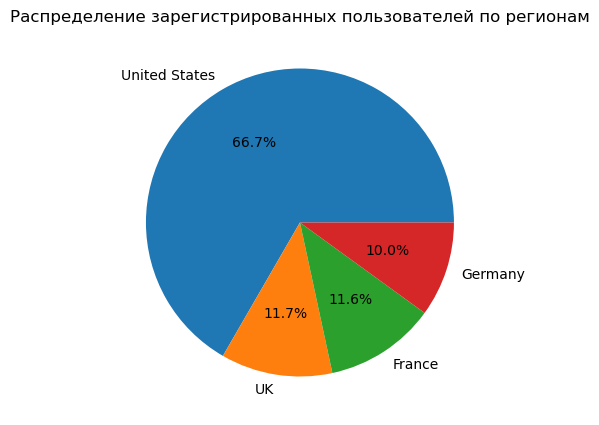

In [23]:
fig, ax = plt.subplots(figsize = (10,5))
ax.pie(countries['user_id'], labels=countries.index, autopct='%1.1f%%')
ax.set_title('Распределение зарегистрированных пользователей по регионам')
plt.show()

А теперь на распределение стран только среди платящих юзеров.

In [24]:
countries2 = profiles.query('payer == True').groupby('region').agg({'user_id': 'count'}).sort_values(by = 'user_id', ascending = False)
countries2.columns = ['payers']
print(countries2)

               payers
region               
United States    6902
UK                700
France            663
Germany           616


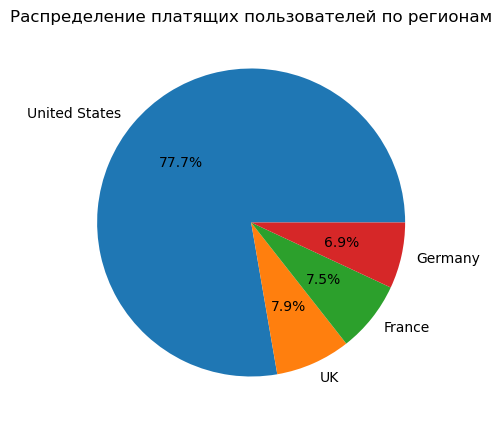

In [25]:
fig, ax = plt.subplots(figsize = (10,5))
ax.pie(countries2['payers'], labels=countries2.index, autopct='%1.1f%%')
ax.set_title('Распределение платящих пользователей по регионам')
plt.show()

Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [26]:
countries = countries.merge(countries2, on = 'region', how = 'left')
countries['ratio'] = (countries2['payers']/countries['user_id']).round(2)
print(countries.sort_values(by = 'ratio', ascending = False))

               user_id  payers  ratio
region                               
United States   100002    6902   0.07
UK               17575     700   0.04
France           17450     663   0.04
Germany          14981     616   0.04


Мы видим, что в США самая высокая доля платящих пользователей, однако все регионы в целом находятся примерно на одном невысоком уровне по доле платящих.

#### Анализ использования устройств и доли платящих в них

Посмотрим, какими девайсами пользуются клиенты. 

In [28]:
devices = profiles.groupby('device').agg({'user_id': 'count'}).sort_values(by = 'user_id', ascending = False)
print(devices)

         user_id
device          
iPhone     54479
Android    35032
PC         30455
Mac        30042


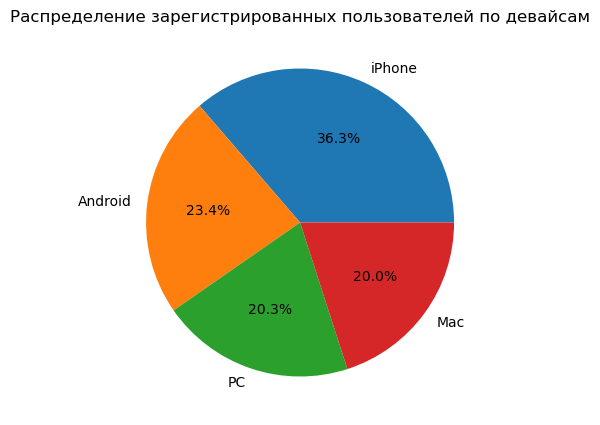

In [29]:
fig, ax = plt.subplots(figsize = (10,5))
ax.pie(devices['user_id'], labels=devices.index, autopct='%1.1f%%')
ax.set_title('Распределение зарегистрированных пользователей по девайсам')
plt.show()

А теперь посмотрим на то, какие девайсы предпочитают платящие пользователи.

In [30]:
devices2 = profiles.query('payer == True').groupby('device').agg({'user_id': 'count'}).sort_values(by = 'user_id', ascending = False)
devices2.columns = ['payers']
print(devices2)

         payers
device         
iPhone     3382
Android    2050
Mac        1912
PC         1537


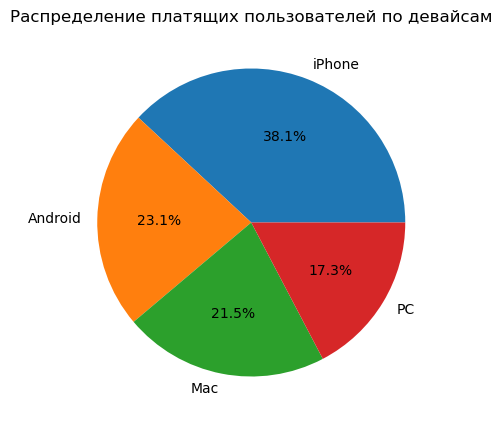

In [31]:
fig, ax = plt.subplots(figsize = (10,5))
ax.pie(devices2['payers'], labels=devices2.index, autopct='%1.1f%%')
ax.set_title('Распределение платящих пользователей по девайсам')
plt.show()

В целом, распределение по устройствам не зависит от того, платящий это клиент или нет. Большая часть девайсов приходится на IPhone, на втором месте Android, на третьем Mac, и на четвертом - PC.

Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [32]:
devices = devices.merge(devices2, on = 'device', how = 'left')
devices['ratio'] = (devices2['payers']/devices['user_id']).round(2)
print(devices.sort_values(by = 'ratio', ascending = False))

         user_id  payers  ratio
device                         
iPhone     54479    3382   0.06
Android    35032    2050   0.06
Mac        30042    1912   0.06
PC         30455    1537   0.05


#### Анализ эффективности каналов привлечения 

Изучим рекламные источники привлечения.

In [33]:
channels = profiles.groupby('channel').agg({'user_id': 'count'}).sort_values(by = 'user_id', ascending = False)
print(channels)

                    user_id
channel                    
organic               56439
FaceBoom              29144
TipTop                19561
OppleCreativeMedia     8605
LeapBob                8553
WahooNetBanner         8553
RocketSuperAds         4448
MediaTornado           4364
YRabbit                4312
AdNonSense             3880
lambdaMediaAds         2149


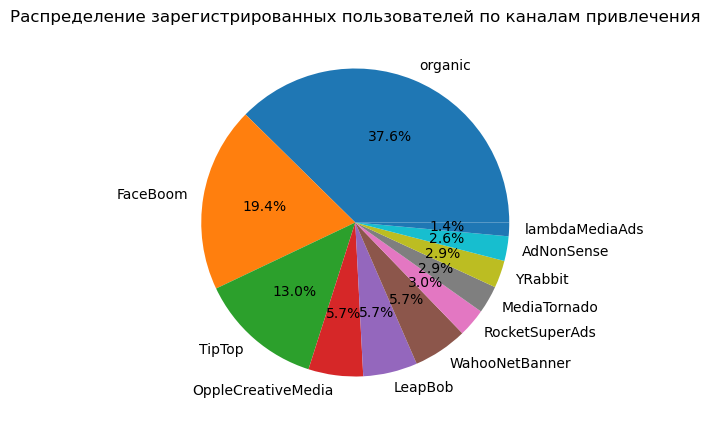

In [34]:
fig, ax = plt.subplots(figsize = (10,5))
ax.pie(channels['user_id'], labels=channels.index, autopct='%1.1f%%')
ax.set_title('Распределение зарегистрированных пользователей по каналам привлечения')
plt.show()

Определим каналы, из которых пришло больше всего платящих пользователей.

In [35]:
channels2 = profiles.query('payer == True').groupby('channel').agg({'user_id': 'count'}).sort_values(by = 'user_id', ascending = False)
channels2.columns = ['payers']
print(channels2)

                    payers
channel                   
FaceBoom              3557
TipTop                1878
organic               1160
WahooNetBanner         453
AdNonSense             440
RocketSuperAds         352
LeapBob                262
OppleCreativeMedia     233
lambdaMediaAds         225
YRabbit                165
MediaTornado           156


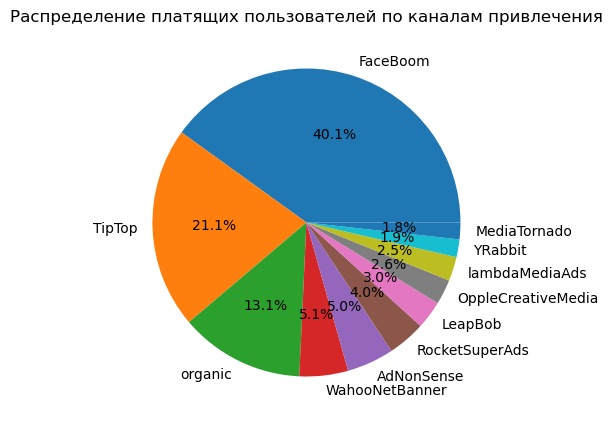

In [36]:
fig, ax = plt.subplots(figsize = (10,5))
ax.pie(channels2['payers'], labels=channels2.index, autopct='%1.1f%%')
ax.set_title('Распределение платящих пользователей по каналам привлечения')
plt.show()

Итак, мы видим, что больше всего органических пользователей, однако среди платящих пользователей - органические только на третьем месте. Больше всего платящих юзеров пришло из канала привлечения FaceBoom, на втором месте - TipTop.

Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [37]:
channels = channels.merge(channels2, on = 'channel', how = 'left')
channels['ratio'] = (channels2['payers']/channels['user_id']).round(2)
channels.sort_values(by = 'ratio', ascending = False)

user_id  payers  ratio
channel                                   
FaceBoom              29144    3557   0.12
AdNonSense             3880     440   0.11
TipTop                19561    1878   0.10
lambdaMediaAds         2149     225   0.10
RocketSuperAds         4448     352   0.08
WahooNetBanner         8553     453   0.05
MediaTornado           4364     156   0.04
YRabbit                4312     165   0.04
OppleCreativeMedia     8605     233   0.03
LeapBob                8553     262   0.03
organic               56439    1160   0.02

Мы составили профили пользователей и изучили, в каких регионах больше всего плательщиков, с каких они сидят устройств, и какие каналы продвижения привели их в наше приложение. Увидели, что конверсия в платящих пользователей выше всего в США, используют плательщики чаще айфоны, а приходят в приложение чаще из FaceBoom. 

### Маркетинг


Посчитаем общую сумму расходов за рассматриваемый период.

In [38]:
print('Общая сумма затрат:', costs['costs'].sum().round(1))

Общая сумма затрат: 105497.3


In [39]:
costs.groupby('channel').agg({'costs':'sum'}).sort_values(by = 'costs', ascending = False)

costs
channel                     
TipTop              54751.30
FaceBoom            32445.60
WahooNetBanner       5151.00
AdNonSense           3911.25
OppleCreativeMedia   2151.25
RocketSuperAds       1833.00
LeapBob              1797.60
lambdaMediaAds       1557.60
MediaTornado          954.48
YRabbit               944.22

#### Распределение расходов на маркетинг по каналам продвижения

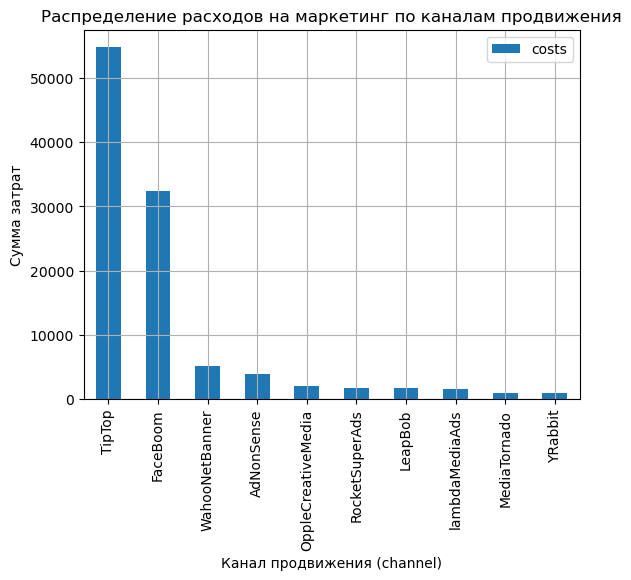

In [40]:
costs_by_channel = costs.groupby('channel').agg({'costs':'sum'}).sort_values(by = 'costs', ascending = False)
costs_by_channel.plot(kind='bar', grid = True);
plt.title('Распределение расходов на маркетинг по каналам продвижения')
plt.xlabel('Канал продвижения (сhannel)')
plt.ylabel('Сумма затрат')
plt.show()

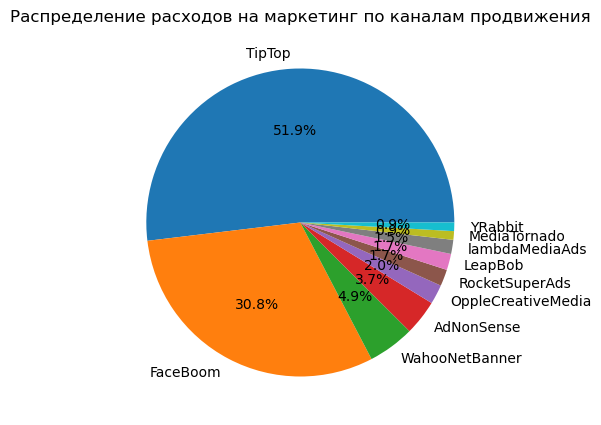

In [41]:
fig, ax = plt.subplots(figsize = (10,5))
ax.pie(costs_by_channel['costs'],  autopct='%1.1f%%', labels=costs_by_channel.index)
ax.set_title('Распределение расходов на маркетинг по каналам продвижения')
plt.show()

Более 80% бюджета было распределено между двумя каналами: TipTop и FaceBoom, на остальные каналы потрачено от 1 до 5% бюджета.

#### Динамика изменения расходов на маркетинг во времени

 Посмотрим на динамику изменения расходов на маркетинг во времени. Для этого создадим два вспомогательных столбца: месяц и неделя,  в которые происходила трата.

In [42]:
costs['monthly_costs'] = pd.DatetimeIndex(pd.to_datetime(costs['dt'])).month
costs['weekly_costs'] = pd.to_datetime(costs['dt']).dt.isocalendar().week
costs.head()

dt   channel  costs  monthly_costs  weekly_costs
0  2019-05-01  FaceBoom  113.3              5            18
1  2019-05-02  FaceBoom   78.1              5            18
2  2019-05-03  FaceBoom   85.8              5            18
3  2019-05-04  FaceBoom  136.4              5            18
4  2019-05-05  FaceBoom  122.1              5            18

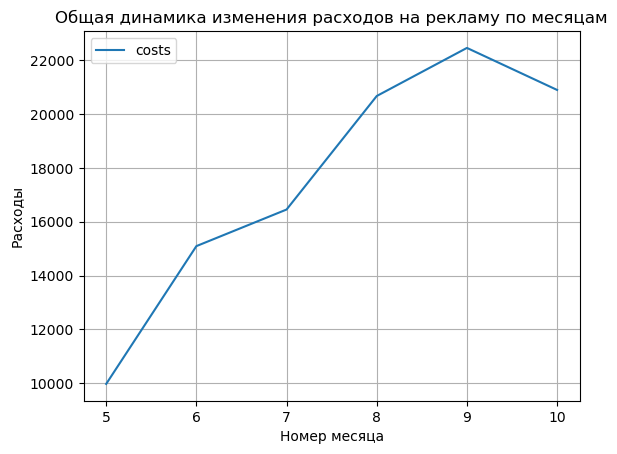

In [43]:
costs.groupby('monthly_costs').agg({'costs':'sum'}).plot(grid = True)
plt.title('Общая динамика изменения расходов на рекламу по месяцам')
plt.xlabel('Номер месяца')
plt.ylabel('Расходы')
plt.show()

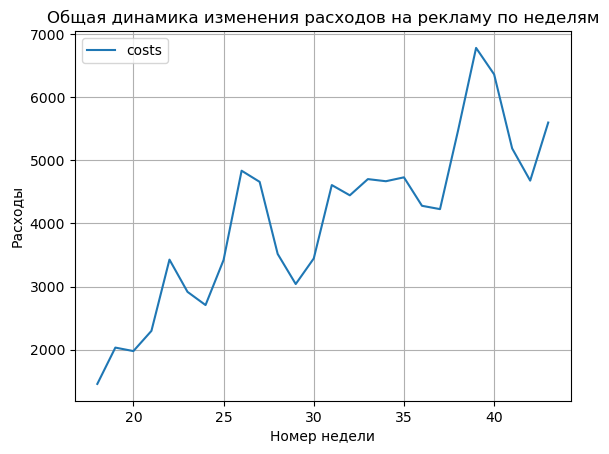

In [44]:
costs.groupby('weekly_costs').agg({'costs':'sum'}).plot(grid = True);
plt.title('Общая динамика изменения расходов на рекламу по неделям')
plt.xlabel('Номер недели')
plt.ylabel('Расходы')
plt.show()

Видим, что с течением времени расходы на маркетинг увеличивались. Посмотрим на динамику в разрезе каналов продвижения.

#### Визуализацию динамики изменения расходов во времени по каналам продвижения

У нас есть 2 лидера (TipTop и FaceBoom), их мы будем рассматривать отдельно от остальных, не лидирующих, каналов.

Посмотрим на траты по двум лидерам.

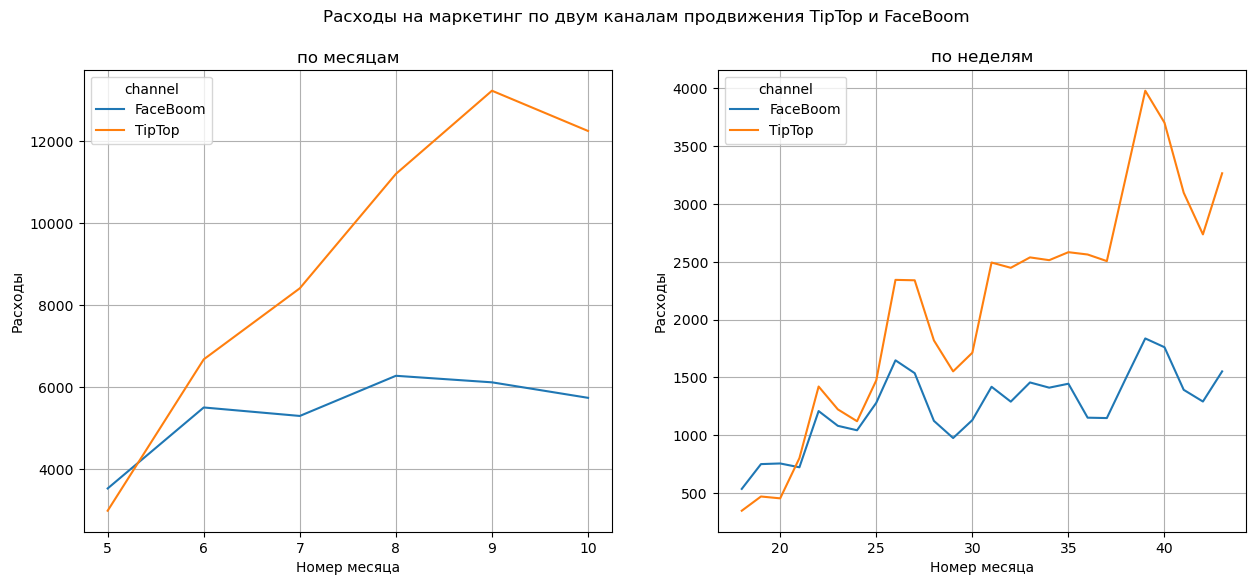

In [45]:
data = costs.query("channel in ['TipTop', 'FaceBoom']").groupby(['monthly_costs', 'channel']).agg({'costs':'sum'})
pivot = pd.pivot_table(data, values='costs', index='monthly_costs', columns='channel')

data2 = costs.query("channel in ['TipTop', 'FaceBoom']").groupby(['weekly_costs', 'channel']).agg({'costs':'sum'})
pivot2 = pd.pivot_table(data2, values='costs', index='weekly_costs', columns='channel')


fig, axes = plt.subplots(1,2, figsize=(15,6))
pivot.plot(kind='line', ax=axes[0], grid = True)
axes[0].set_xlabel('Номер месяца')
axes[0].set_ylabel('Расходы')
axes[0].set_title("по месяцам") 
pivot2.plot(kind='line', ax=axes[1], grid = True)
axes[1].set_xlabel('Номер месяца')
axes[1].set_ylabel('Расходы')
axes[1].set_title("по неделям") 
fig.suptitle('Расходы на маркетинг по двум каналам продвижения TipTop и FaceBoom', fontsize=12)
plt.show()

Видим, что по месяцам траты все время росли, в канал TipTop почти с самого начало вкладывалось больше денег, в какие-то месяцы более чем в два раза, чем в FaceBoom. 
По недельному графику видим, что траты в целом росли, но по неделям не очень равномерно, когда-то вкладывалось больше, чем на прошлой неделе, когда-то - меньше.

Посмотрим на траты по остальным каналам продвижения.

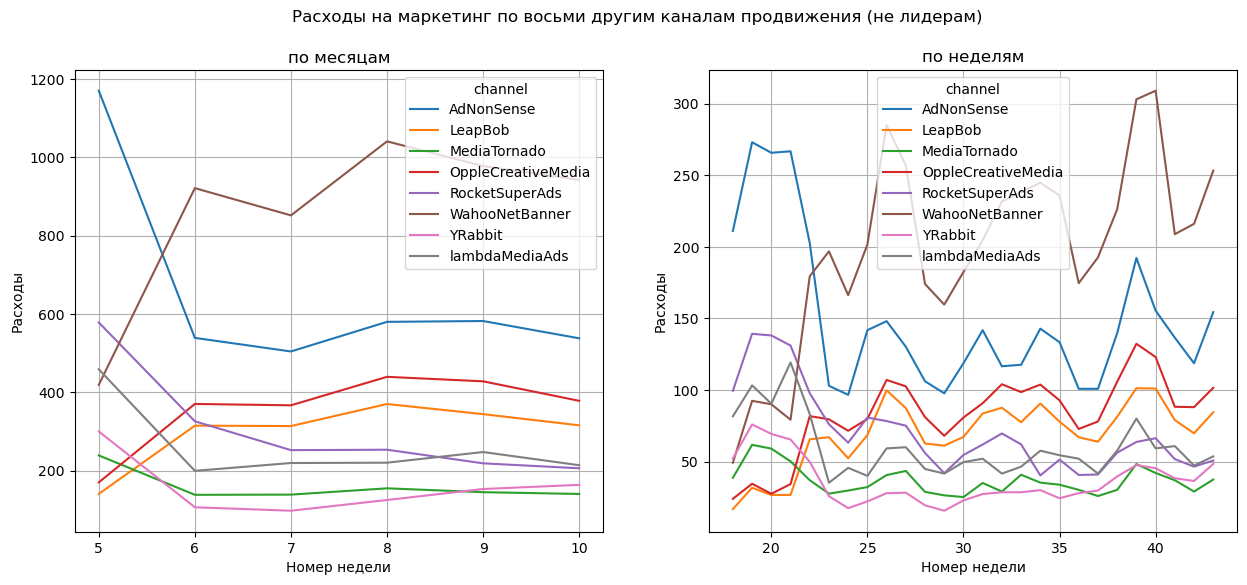

In [46]:
data = costs.query("channel not in ['TipTop', 'FaceBoom']").groupby(['monthly_costs', 'channel']).agg({'costs':'sum'})
pivot = pd.pivot_table(data, values='costs', index='monthly_costs', columns='channel')

data2 = costs.query("channel not in ['TipTop', 'FaceBoom']").groupby(['weekly_costs', 'channel']).agg({'costs':'sum'})
pivot2 = pd.pivot_table(data2, values='costs', index='weekly_costs', columns='channel')


fig, axes = plt.subplots(1,2, figsize=(15,6))
pivot.plot(kind='line', ax=axes[0], grid=True)
axes[0].set_xlabel('Номер недели')
axes[0].set_ylabel('Расходы')
axes[0].set_title("по месяцам") 
pivot2.plot(kind='line', ax=axes[1],grid=True)
axes[1].set_xlabel('Номер недели')
axes[1].set_ylabel('Расходы')
axes[1].set_title("по неделям") 
fig.suptitle('Расходы на маркетинг по восьми другим каналам продвижения (не лидерам)', fontsize=12)
plt.show()

Здесь мы видим, что в мае почти во все каналы было вложено больше средств, чем в июне и в последние месяцы. Только у WahooNetBanner размер вложенных средств рос.

#### Стоимость привлечения пользователя

Посмотрим, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. То есть посчитаем сумму денег, в которую компании обходится каждый новый клиент.

Посчитаем количество уникальных пользователей с одинаковыми источником и датой привлечения.

In [47]:
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )

Объединяем траты на рекламу и число привлечённых пользователей по дате и каналу привлечения.

In [48]:
costs = costs.merge(new_users, on=['dt', 'channel'], how='left')
costs.head()

dt   channel  costs  monthly_costs  weekly_costs  unique_users
0  2019-05-01  FaceBoom  113.3              5            18           104
1  2019-05-02  FaceBoom   78.1              5            18            72
2  2019-05-03  FaceBoom   85.8              5            18            76
3  2019-05-04  FaceBoom  136.4              5            18           123
4  2019-05-05  FaceBoom  122.1              5            18           113

In [49]:
costs['acquisition_cost'] = costs['costs'] / costs['unique_users']
channel_mean_costs = costs.groupby('channel').agg({'acquisition_cost':'mean'}).round(2).sort_values(by = 'acquisition_cost', ascending = False)
channel_mean_costs

acquisition_cost
channel                             
TipTop                          2.66
FaceBoom                        1.11
AdNonSense                      1.01
lambdaMediaAds                  0.72
WahooNetBanner                  0.60
RocketSuperAds                  0.41
OppleCreativeMedia              0.25
MediaTornado                    0.22
LeapBob                         0.21
YRabbit                         0.21

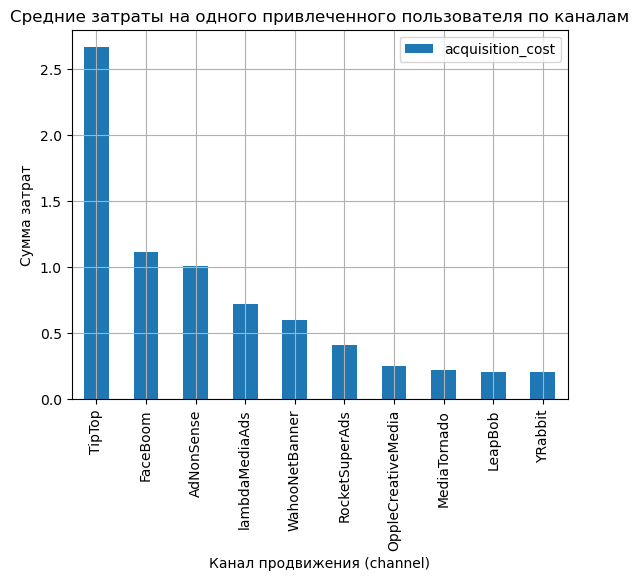

In [50]:
channel_mean_costs.plot(kind = 'bar', grid=True)
plt.title('Средние затраты на одного привлеченного пользователя по каналам')
plt.xlabel('Канал продвижения (сhannel)')
plt.ylabel('Сумма затрат')
plt.show()

Таким образом, с отрывом более чем в два раза идет TipTop (2,7), на остальные каналы на одного пользвателя уходит от 1,1 до 0,2.

### Оценка окупаемости рекламы

Проанализируем окупаемость рекламы. В бизнес-плане заложено, что пользователи должны окупаться не позднее, чем через две недели после привлечения. Посмотрим, выполняется ли это требование. Органических клиентов в расчетах учитывать не будем. 

In [51]:
profiles = profiles.query('channel != "organic"') # исключаем органику

In [52]:
observation_date = datetime(2019, 11, 1).date() # момент анализа
horizon_days = 14 # горизонт анализа 

#### LTV, ROI, CAC

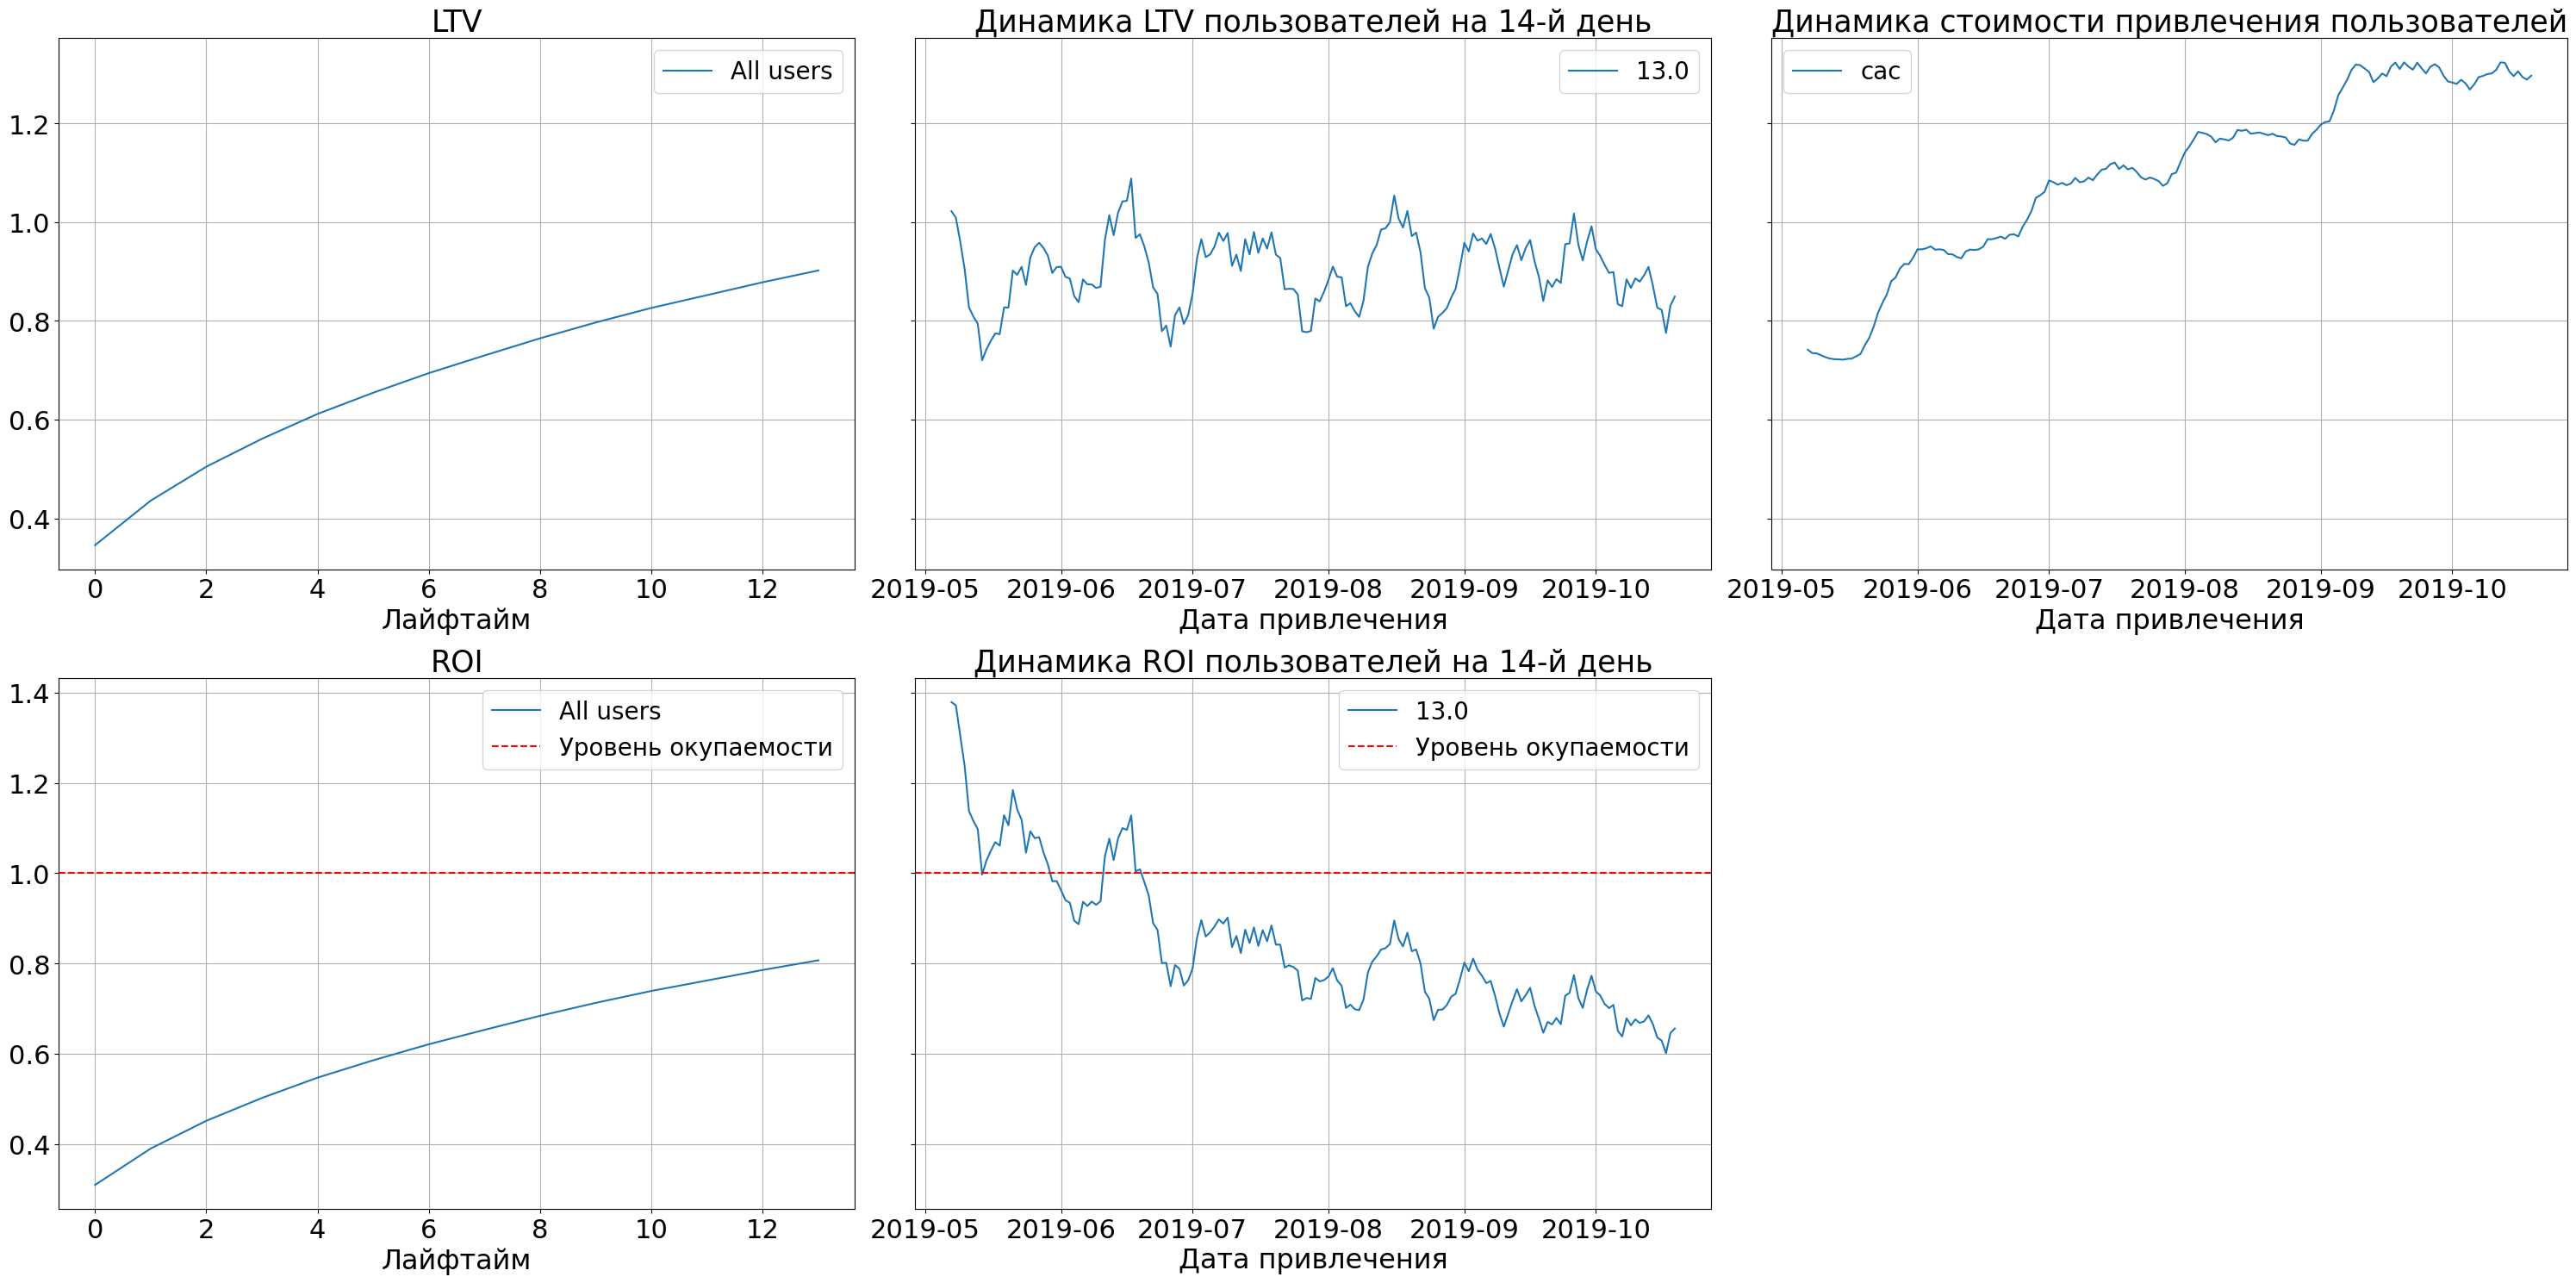

In [53]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Реклама не окупается. ROI к концу второй недели — 80%. Стоимость привлечения пользователей стабильно растет.

Чтобы понять причины, декомпозируем весь трафик по странам, устройствам и регионам и найдем, где конкретно и в какой момент происходит проблема.

#### LTV, ROI, CAC по устройствам

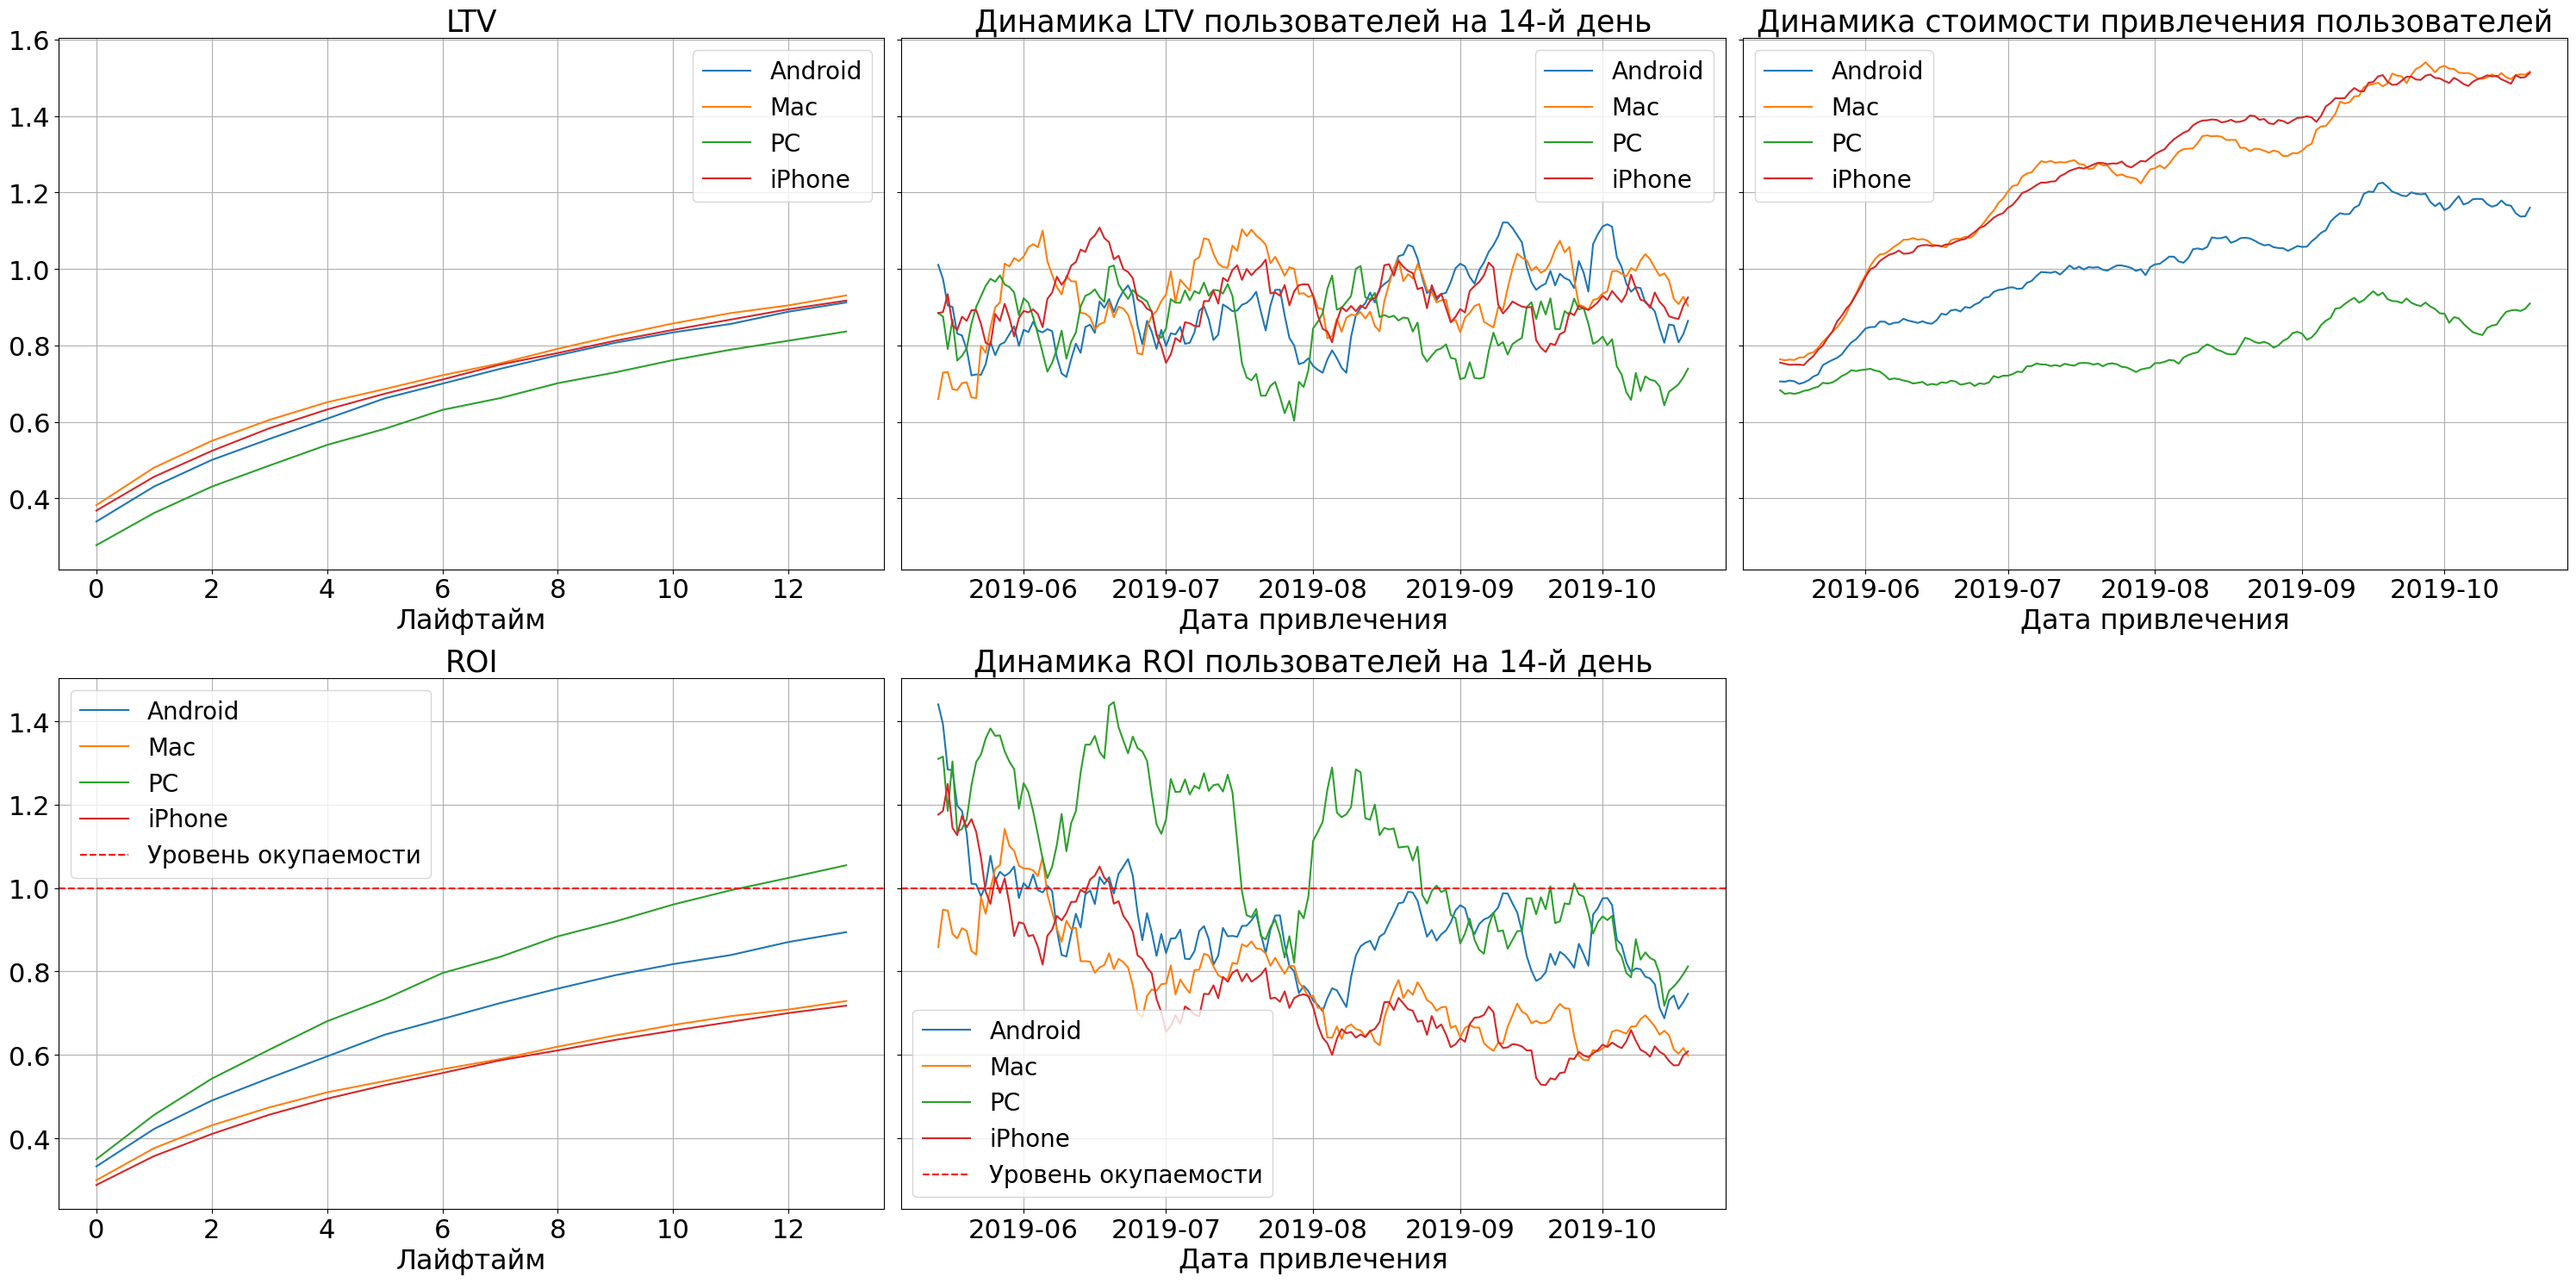

In [54]:
dimensions = ['device'] #анализ с разбивкой по устройствам

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

На PC реклама окупается. На Android, IPhone и Mac - не окупается. Динамика ROI отрицательная для всех устройств. Стоимость привлечения растет для всех устройств, для PC - в самой меньшей степени. 

#### LTV, ROI, CAC по странам

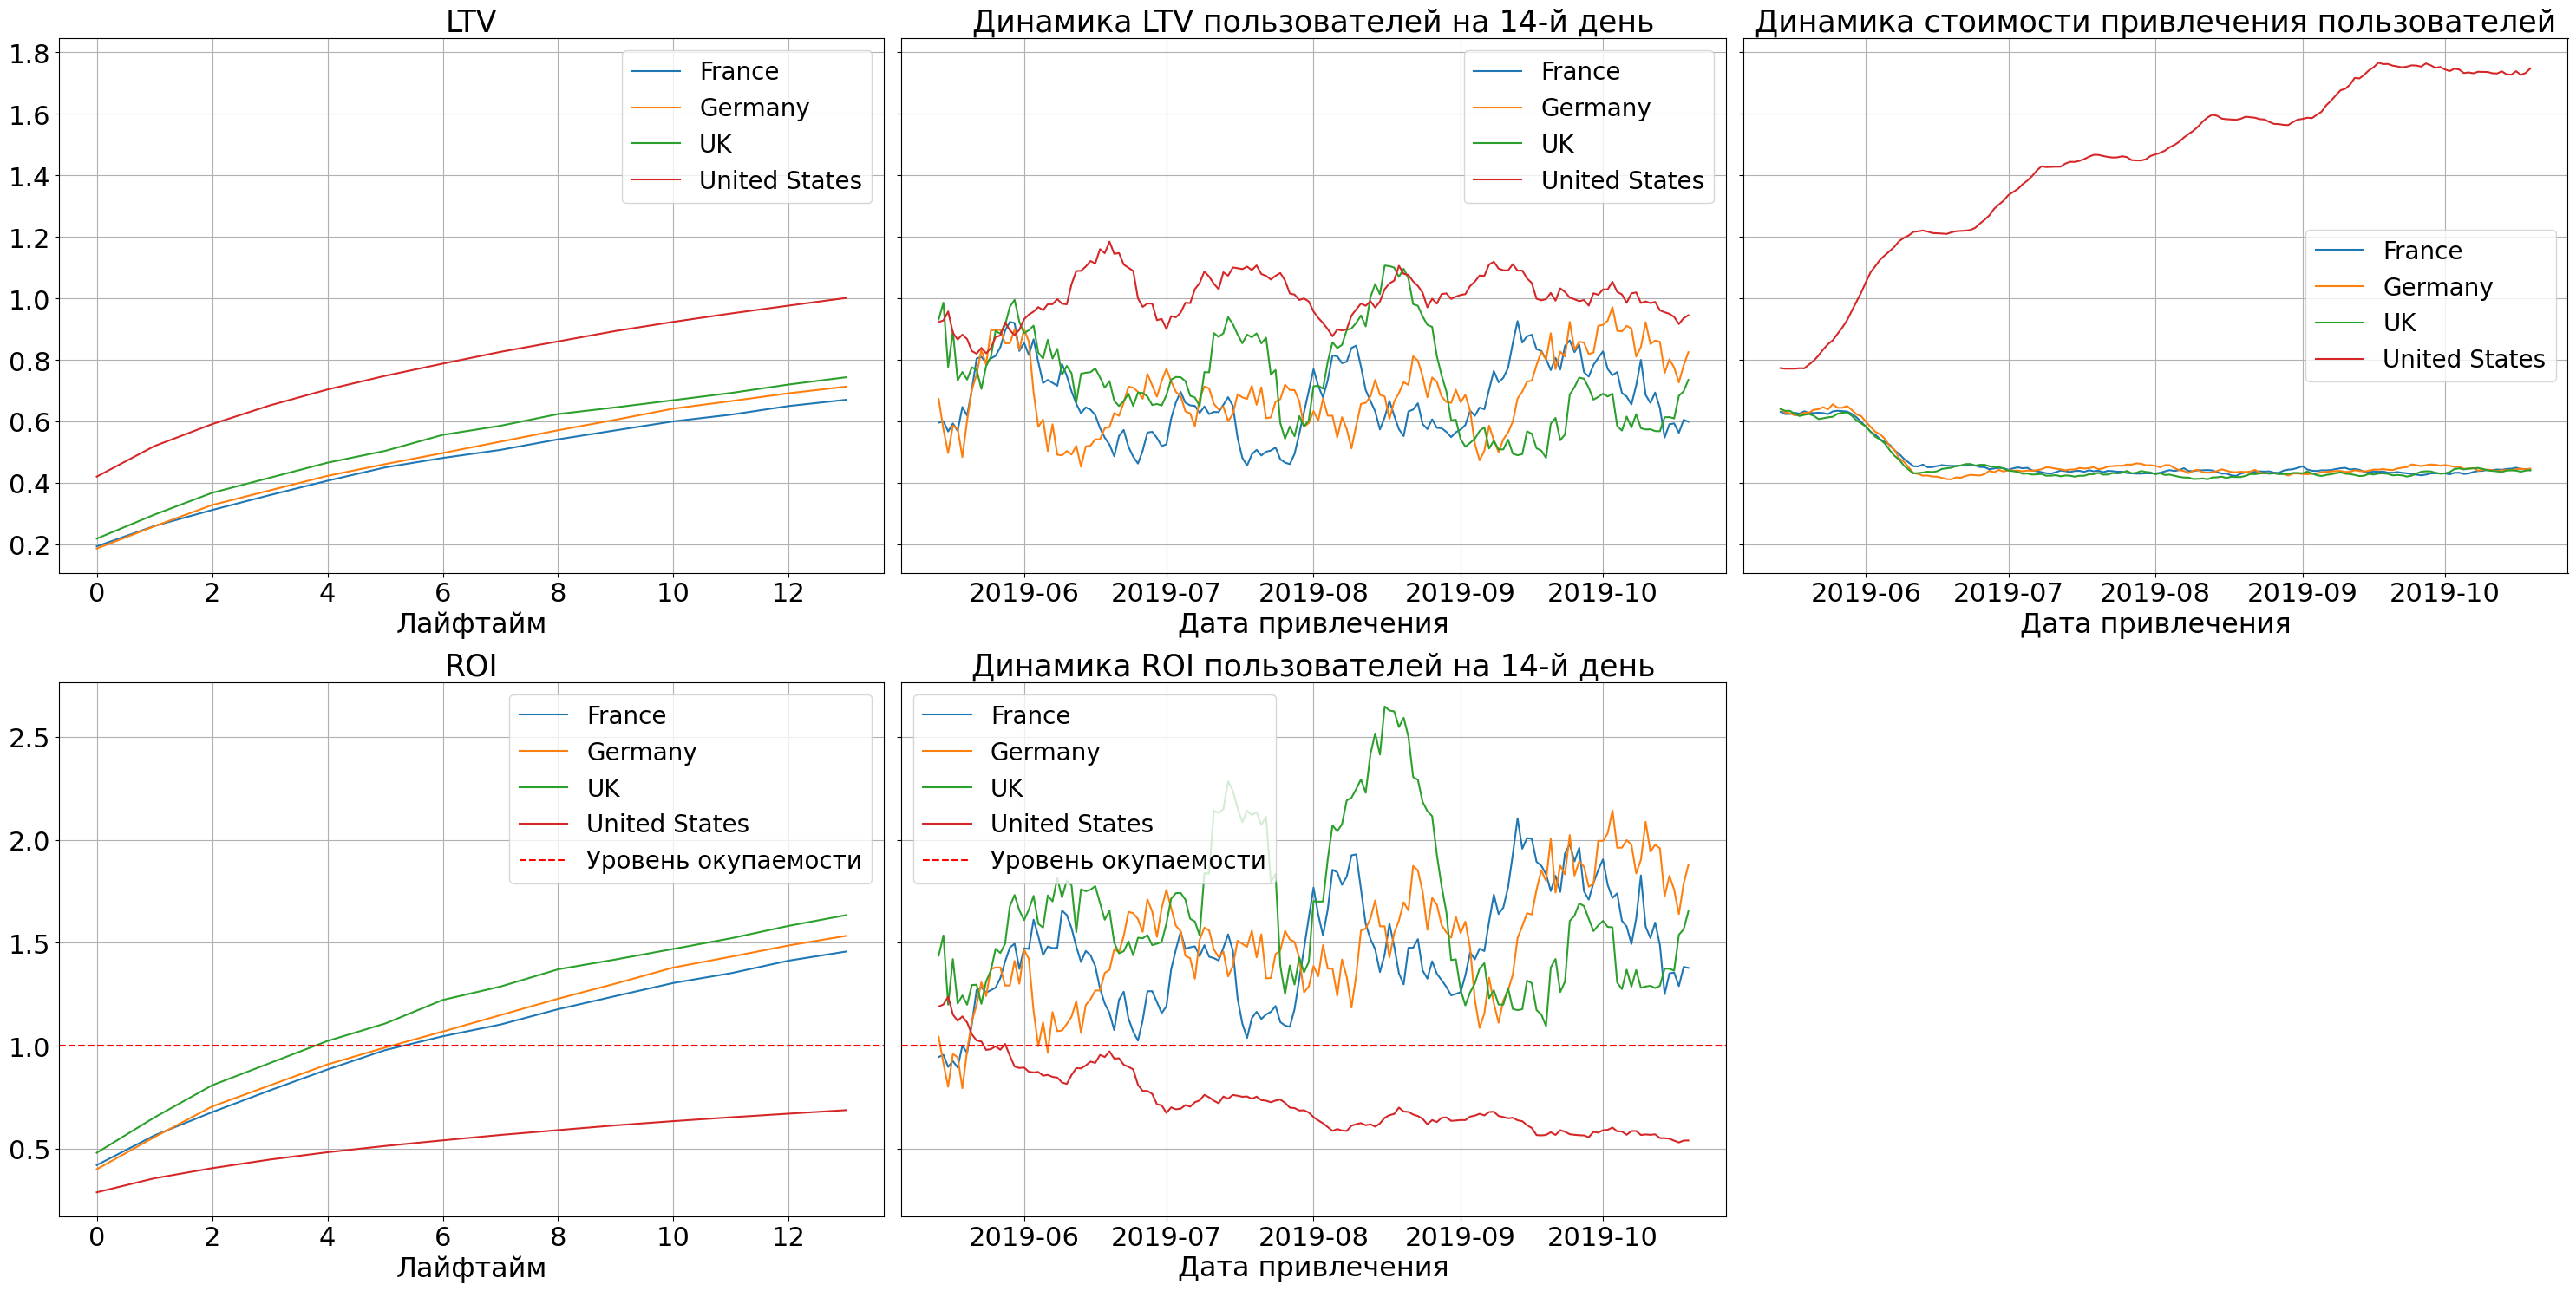

In [55]:
dimensions = ['region'] # анализ с разбивкой по регионам

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

США заметно отличается от остальных стран. Стоимость привлечения по всем странам, кроме США, падает, и реклама во всех странах, кроме США, выходит на окупаемость.

#### LTV, ROI, CAC по каналам привлечения

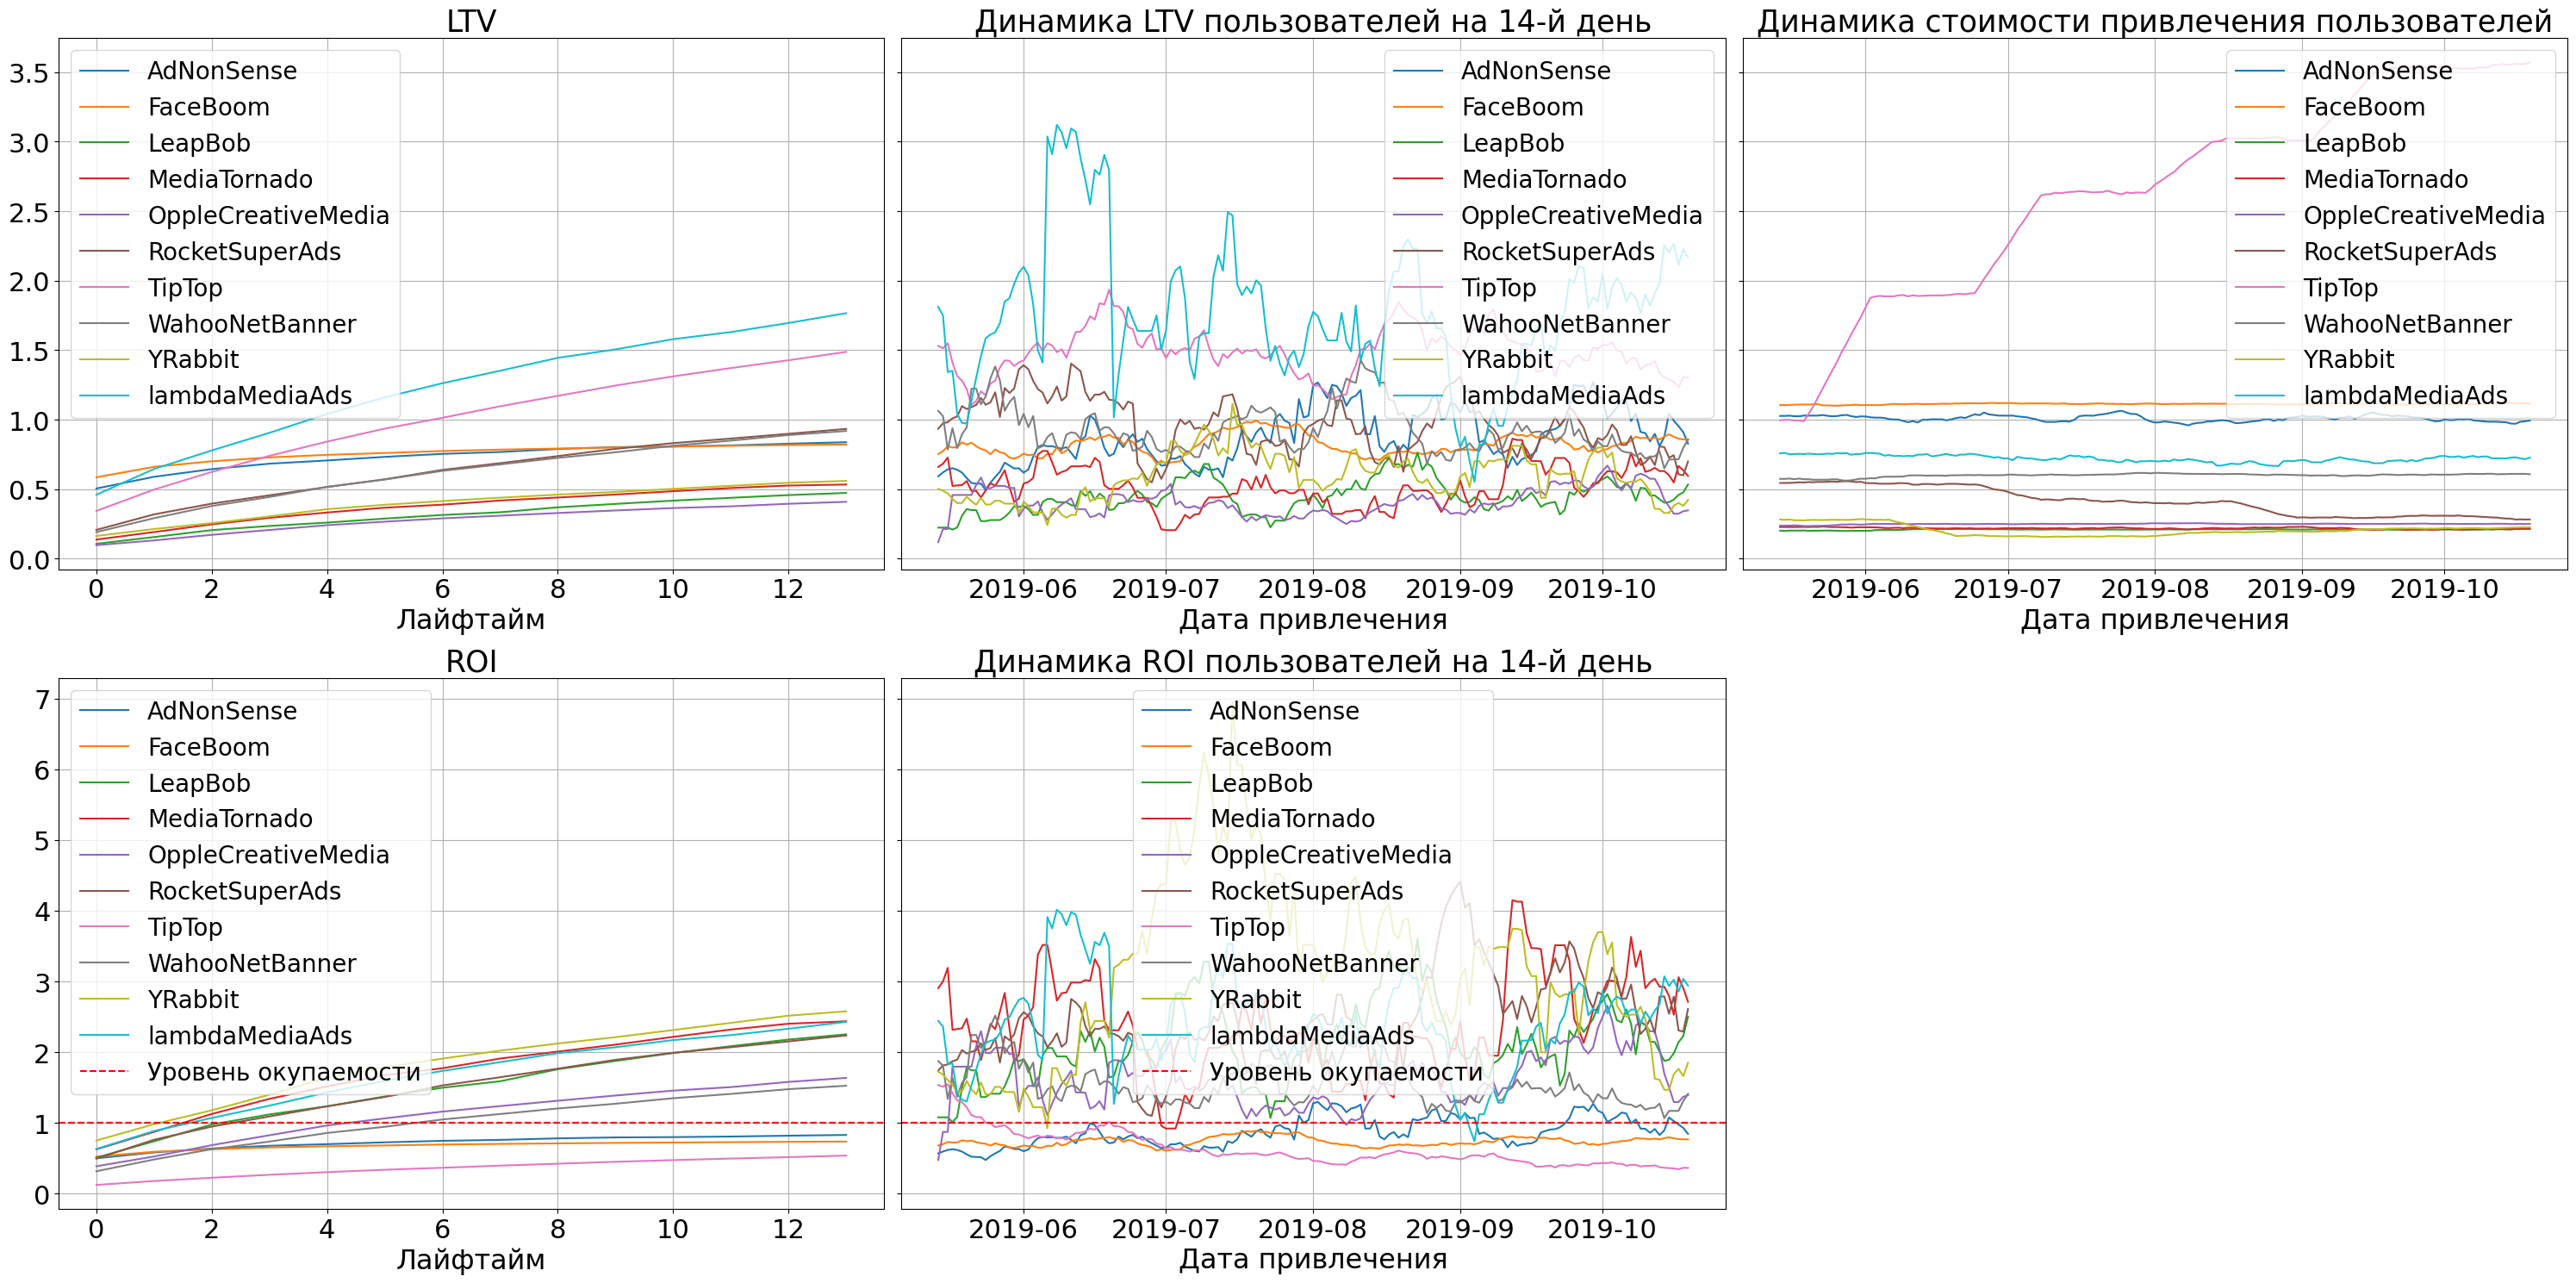

In [56]:
dimensions = ['channel'] # анализ с разбивкой по каналам привлечения

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Только три канала привлечения находятся ниже уровня окупаемости: TipTop, FaceBoom, AdNonSense. Стоимости привлечения достаточно стабильны везде, кроме TipTop, у которого стоимость сильно растет со временем.

Посмотрим, в каких странах работают эти каналы привлечения:

In [57]:
print('TipTop используется в:', profiles.loc[profiles['channel'] == 'TipTop']['region'].unique())
print('FaceBoom используется в:', profiles.loc[profiles['channel'] == 'FaceBoom']['region'].unique())
print('AdNonSense используется в:', profiles.loc[profiles['channel'] == 'AdNonSense']['region'].unique())

TipTop используется в: ['United States']
FaceBoom используется в: ['United States']
AdNonSense используется в: ['Germany' 'France' 'UK']


А теперь проверим, какие еще из каналов привлечения работают на рынке США.

In [58]:
print(profiles.loc[profiles['region'] == 'United States']['channel'].unique())

['FaceBoom' 'YRabbit' 'MediaTornado' 'RocketSuperAds' 'TipTop']


Увидели, что в США работают несколько каналов привлечения, два крупнейших из которых показывают отрицательные результаты.

#### Конверсия и удержание пользователей

Проверим конверсию и удержание пользователей и динамику их изменения. Построим графики конверсии и удержания.

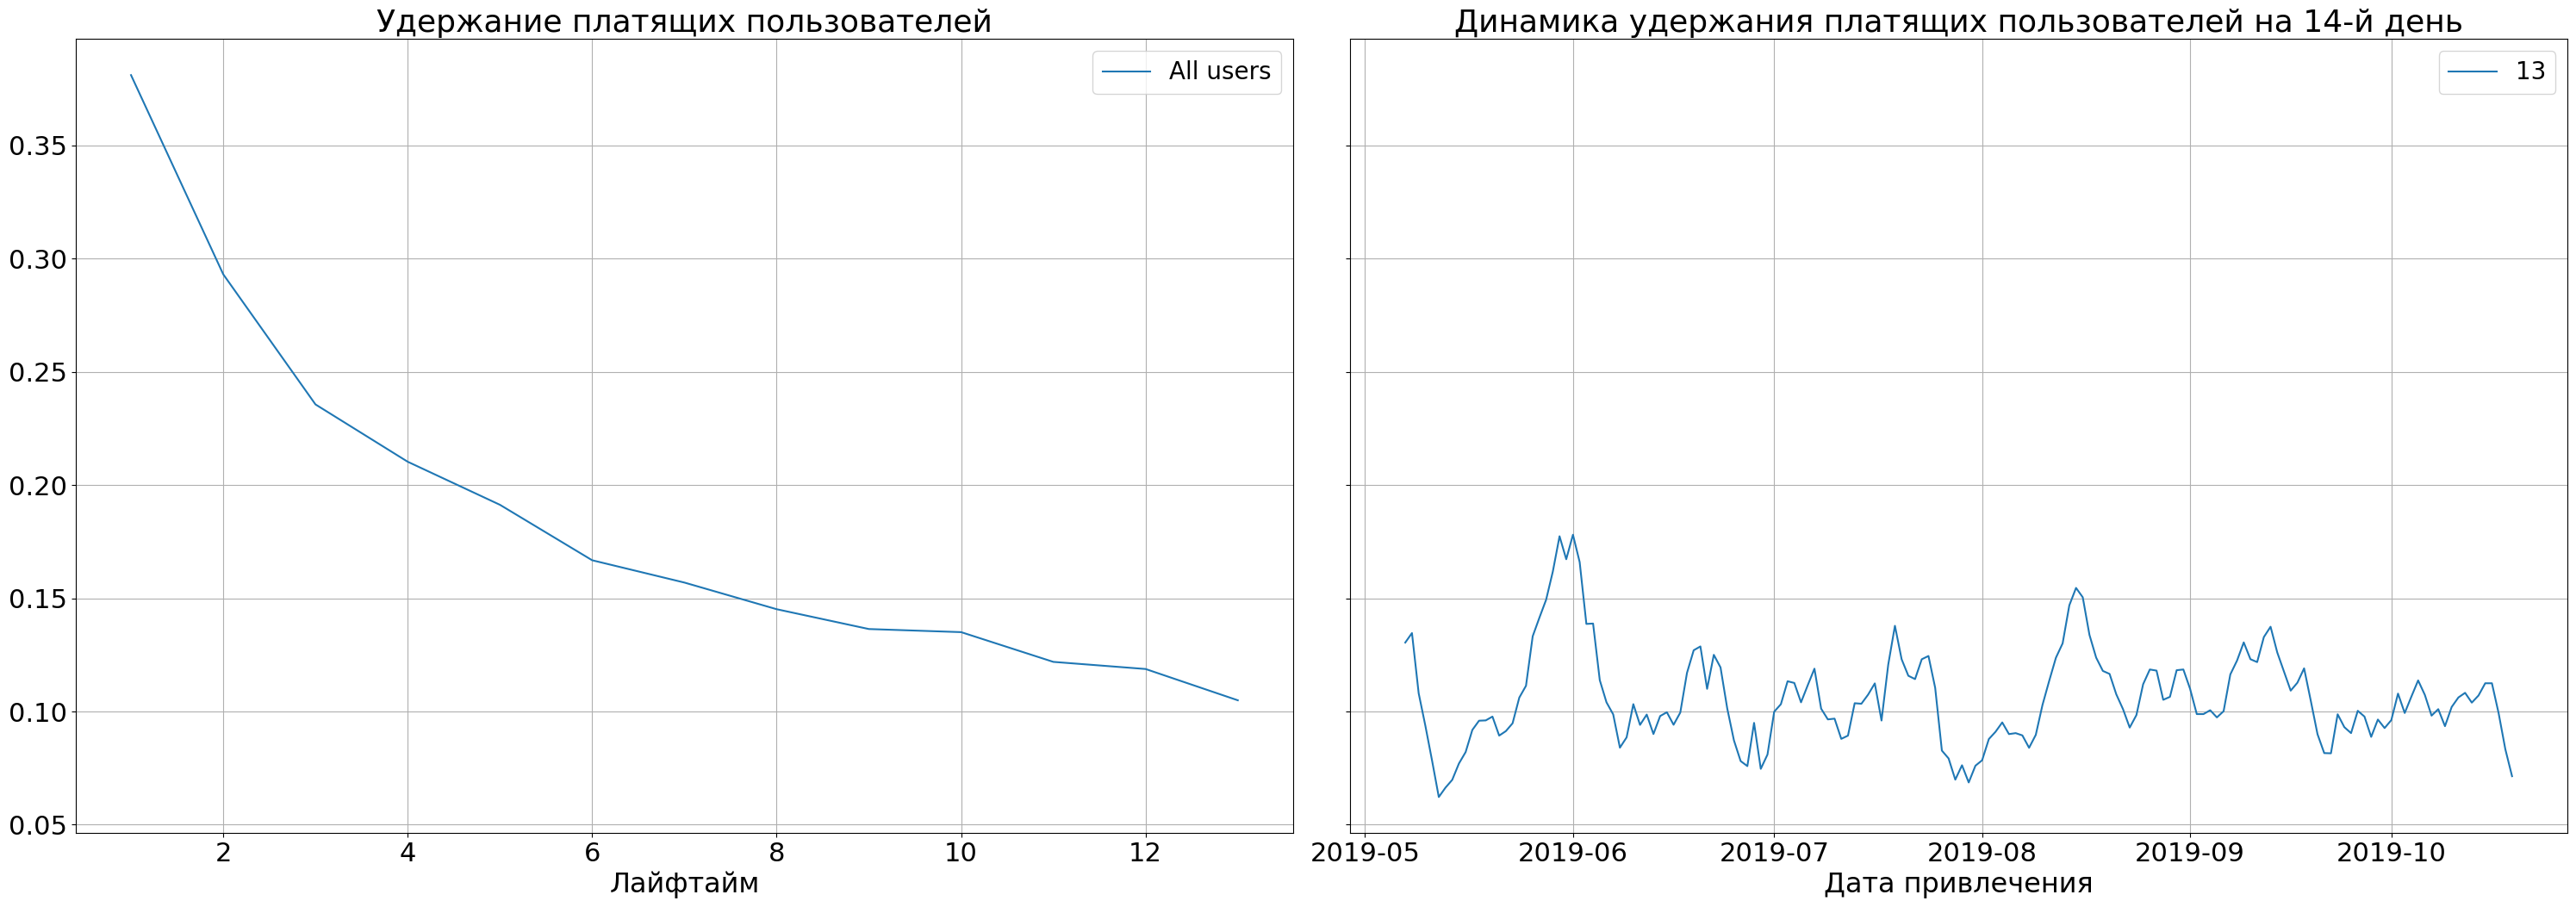

In [59]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days)

plot_retention(retention_grouped, retention_history, horizon_days)

Удержание пользователей на очень низком уровне, к концу второй недели удерживается всего 10% пользователей. В течение рассматриваемого периода удержание находится примерно на одном уровне, и незначительно колеблется согласна сезонности.

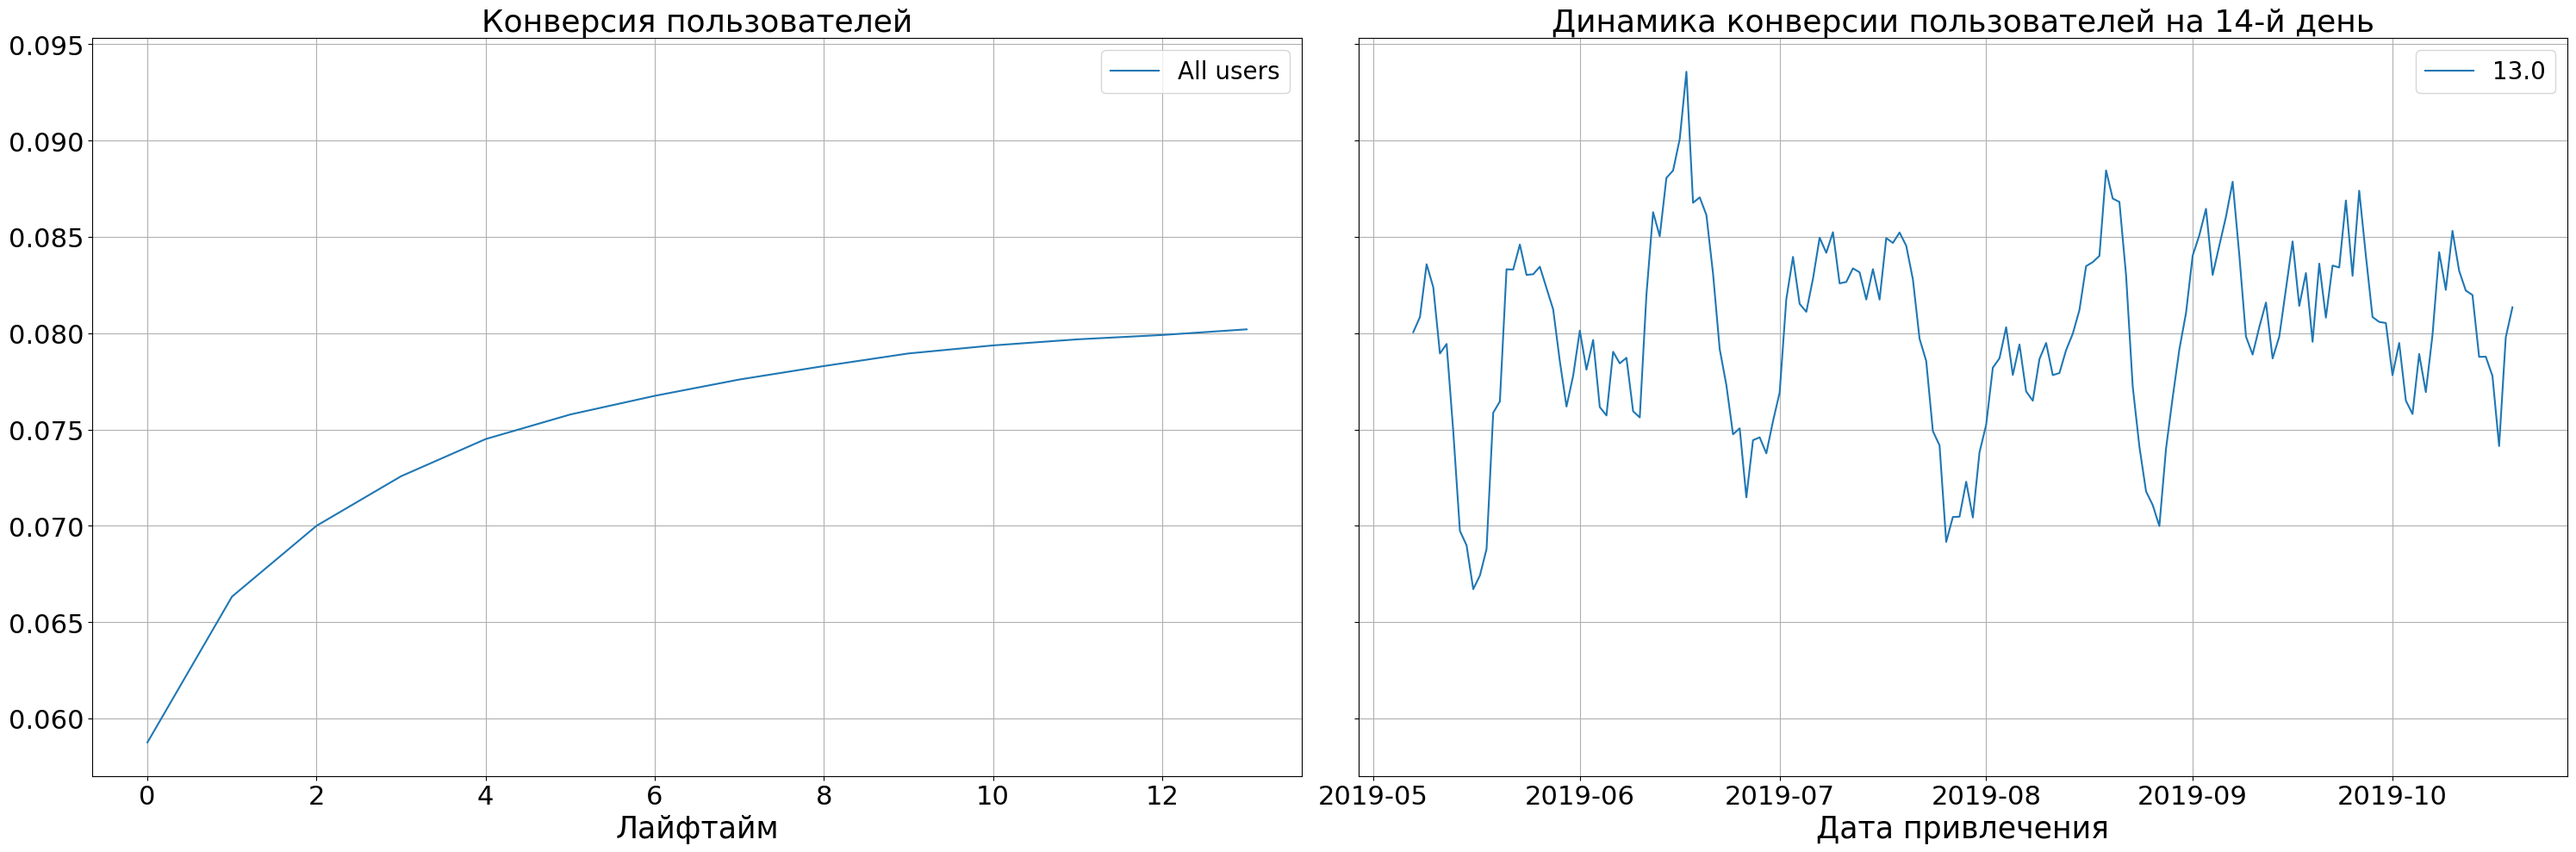

In [60]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Конверсия растет со временем и составляет 8% к концу второй недели. Динамики нет, в течение всего срока примерно одинаковые сезонные колебания.

Проведем такой же анализ с разбивкой по устройствам, странам и рекламным каналам.

#### Конверсия и удержание пользователей по устройствам

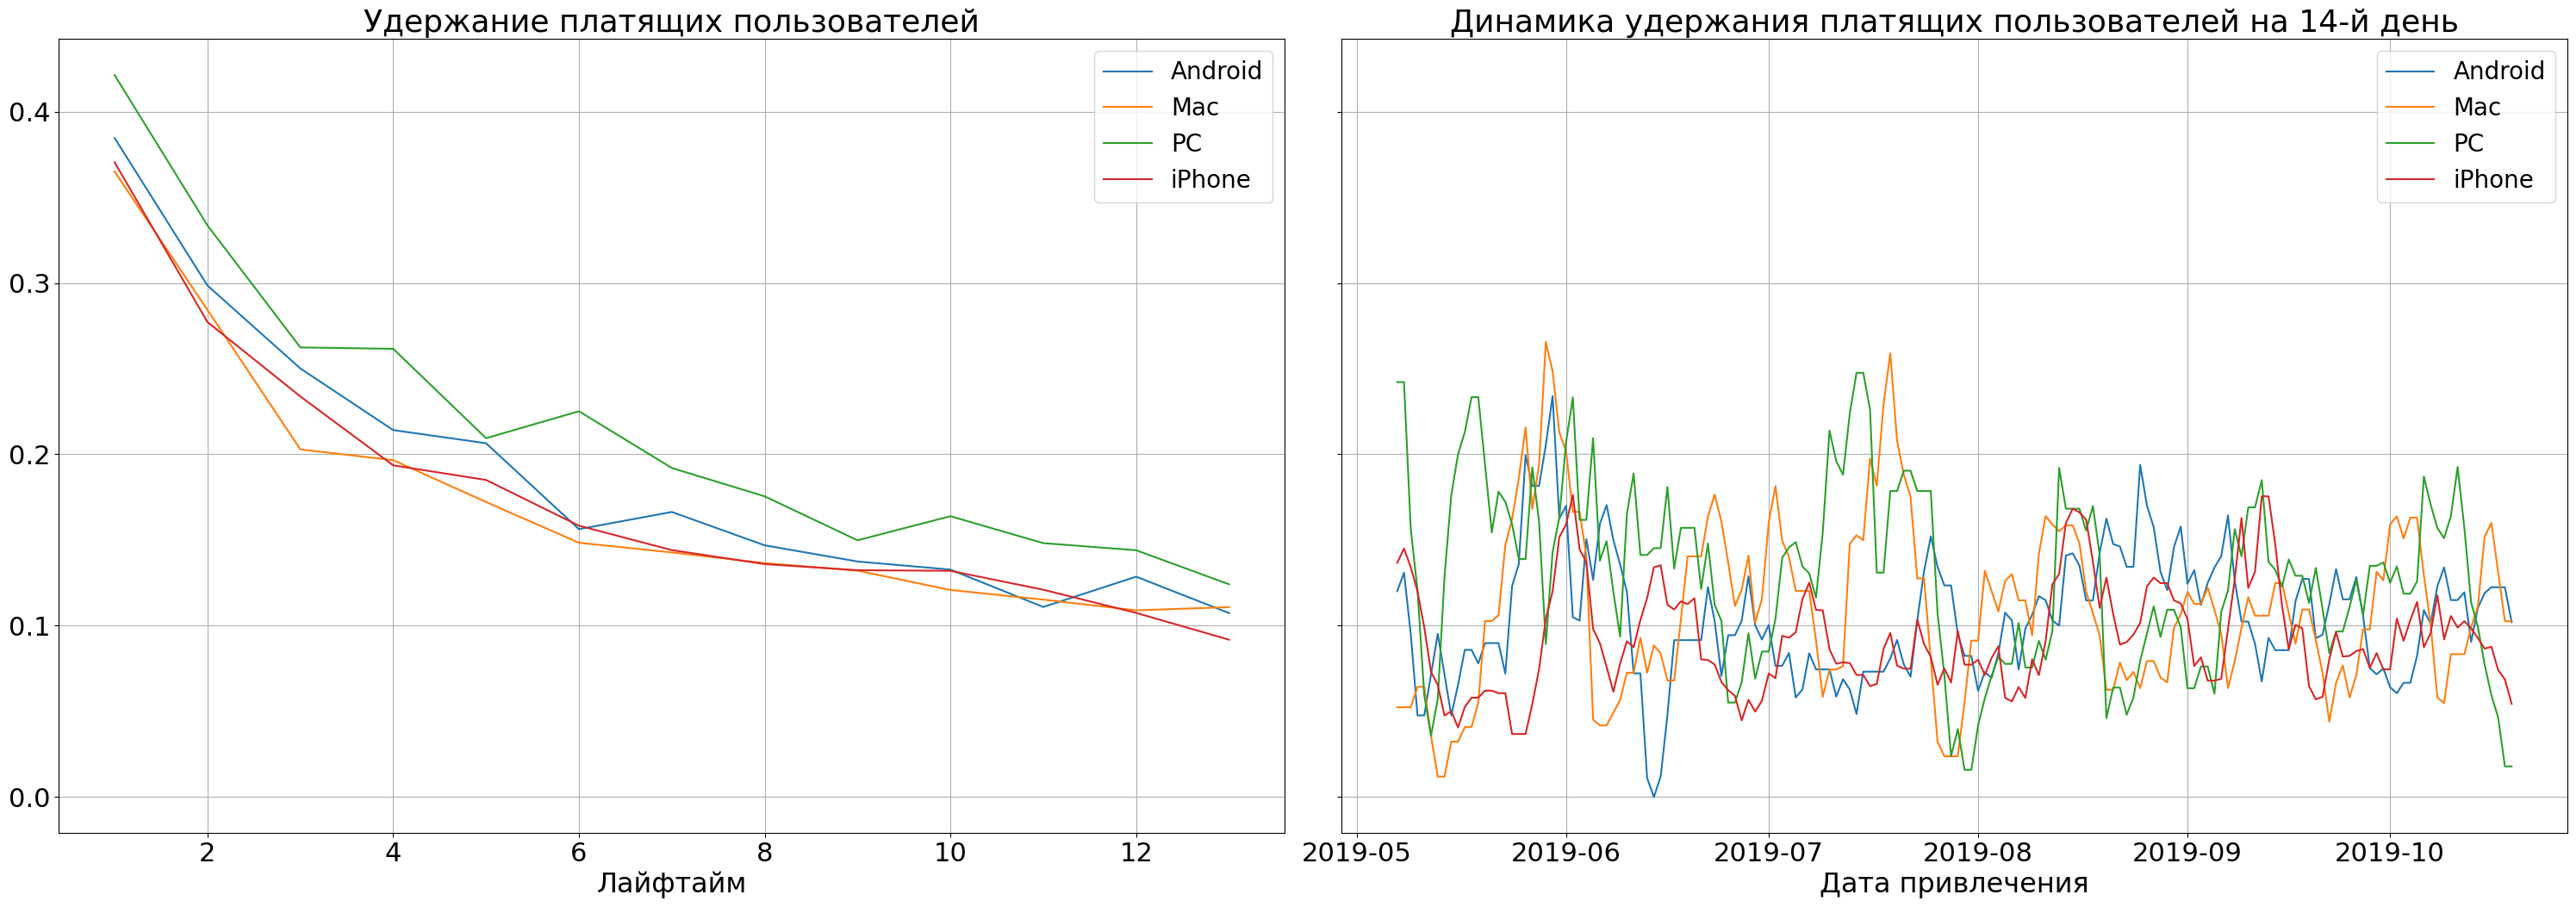

In [61]:
dimensions = ['device'] # удержание с разбивкой по устройствам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions)

plot_retention(retention_grouped, retention_history, horizon_days)

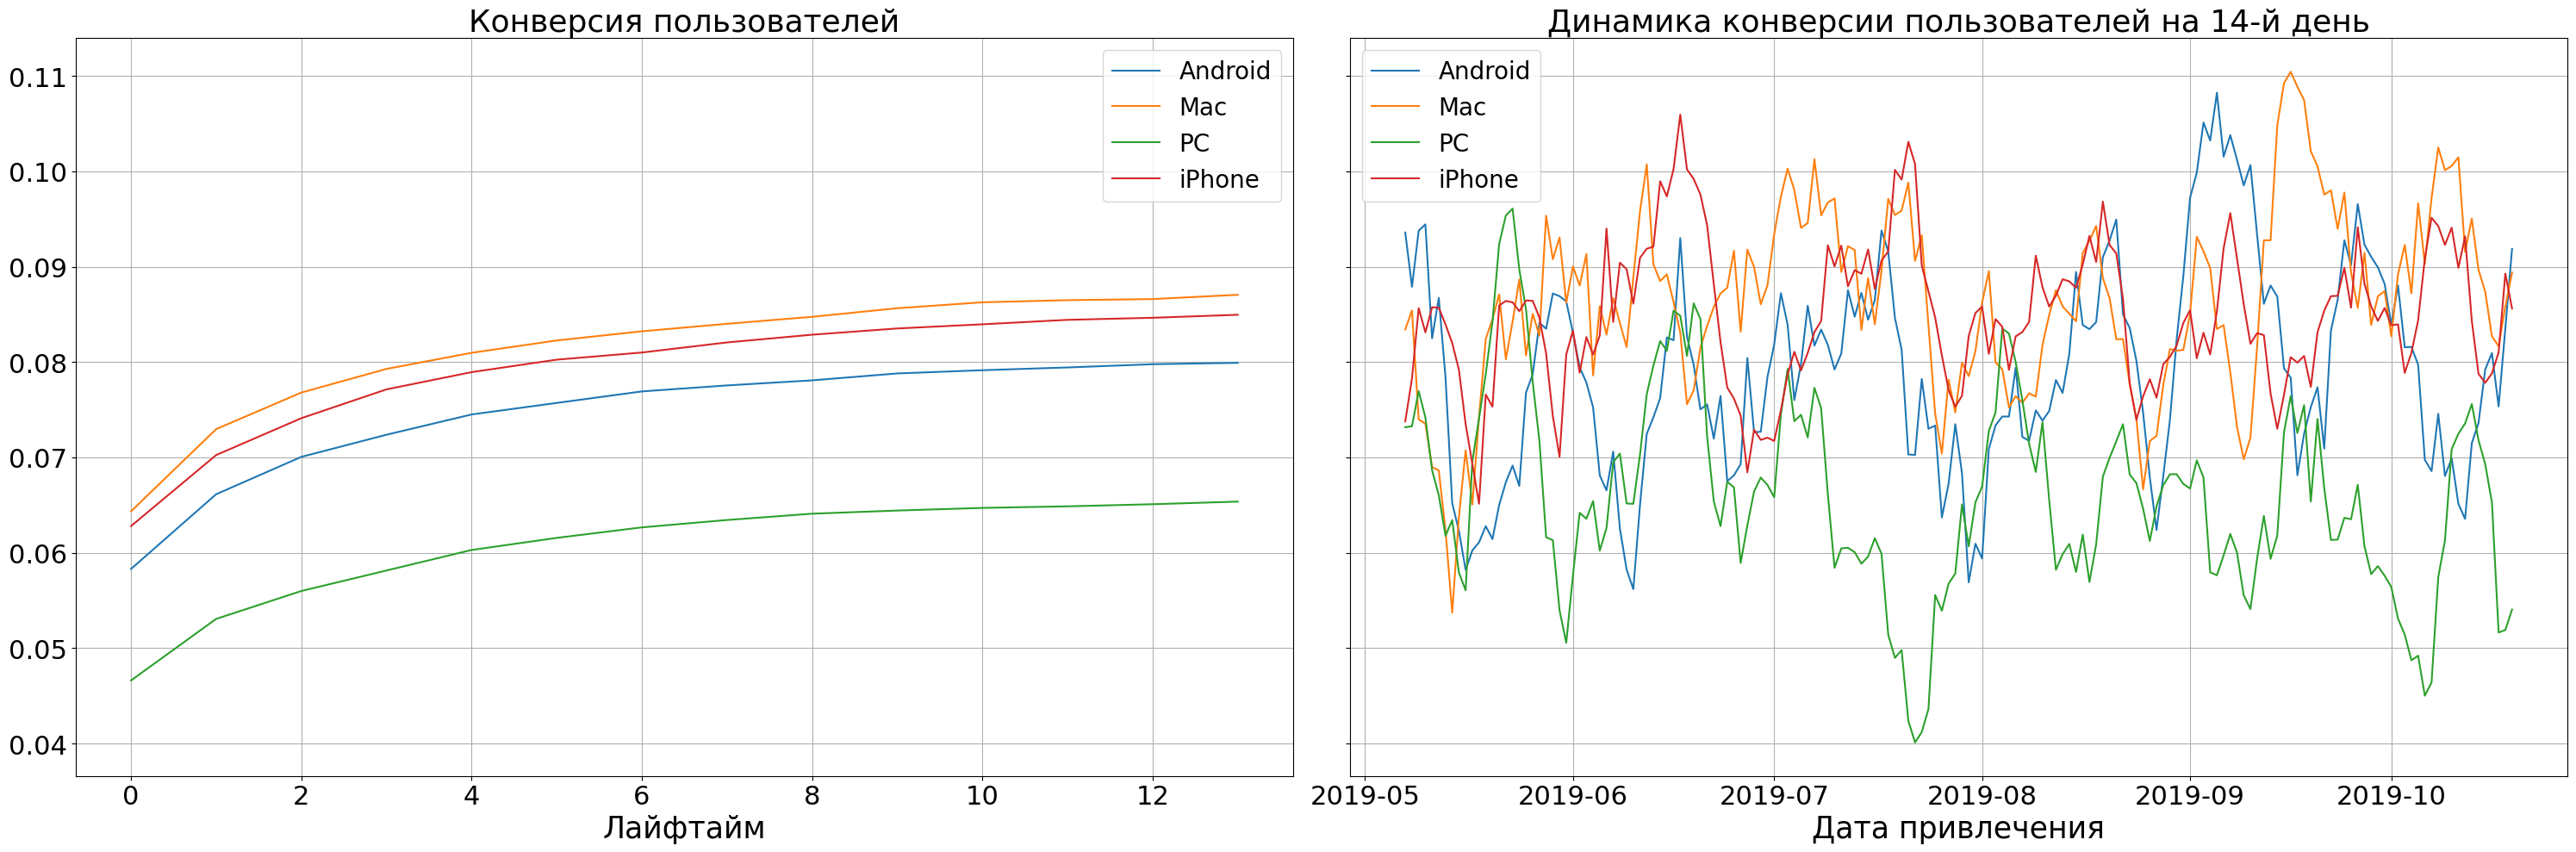

In [62]:
dimensions = ['device'] #конверсия с разбивкой по устройствам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Удержание не сильно различается в зависимости от устройства, а вот конверсия пользователей ПК отстает от других устройств в среднем на 1,5-2,5%.

#### Конверсия и удержание пользователей по странам

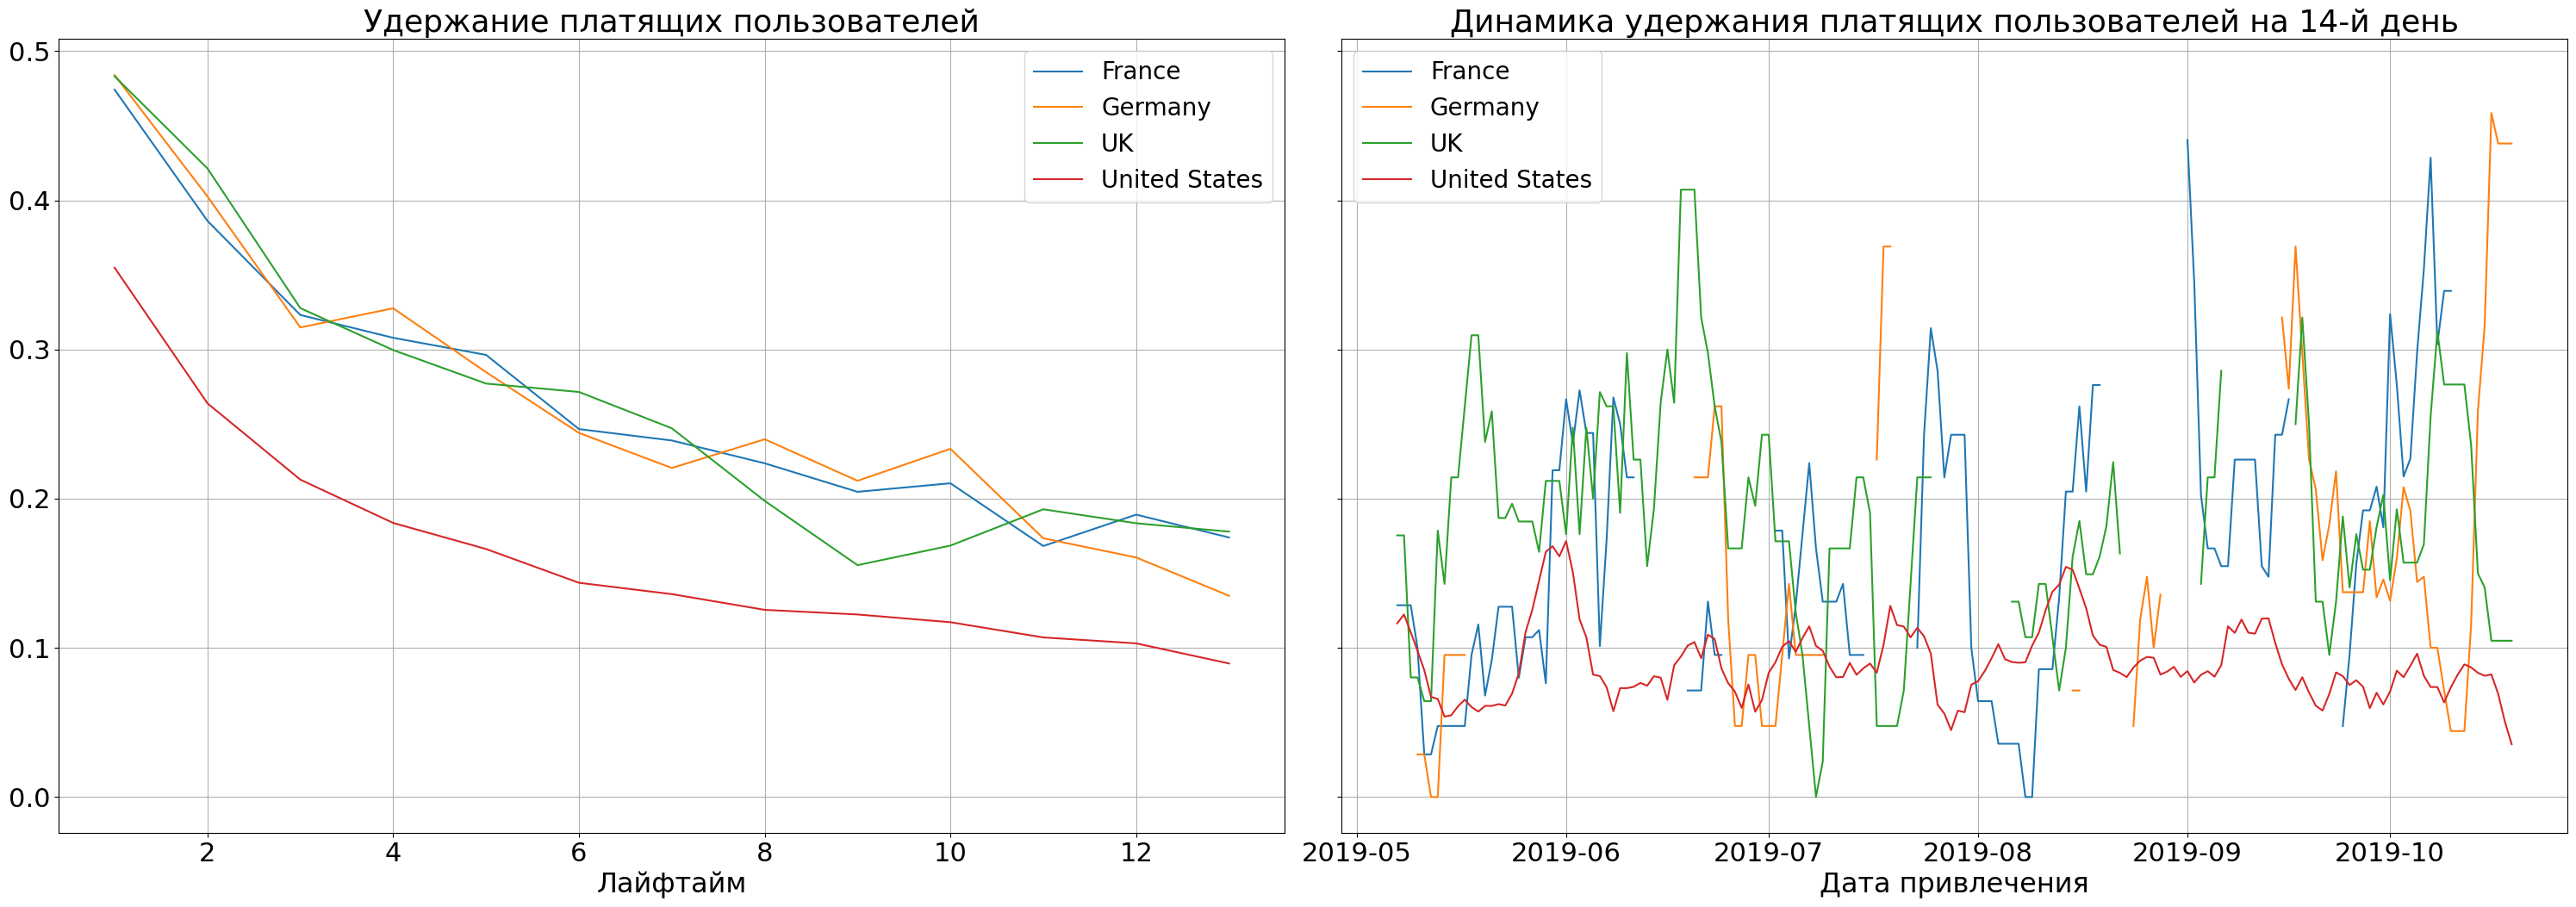

In [63]:
dimensions = ['region'] # удержание с разбивкой по регионам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions)

plot_retention(retention_grouped, retention_history, horizon_days)

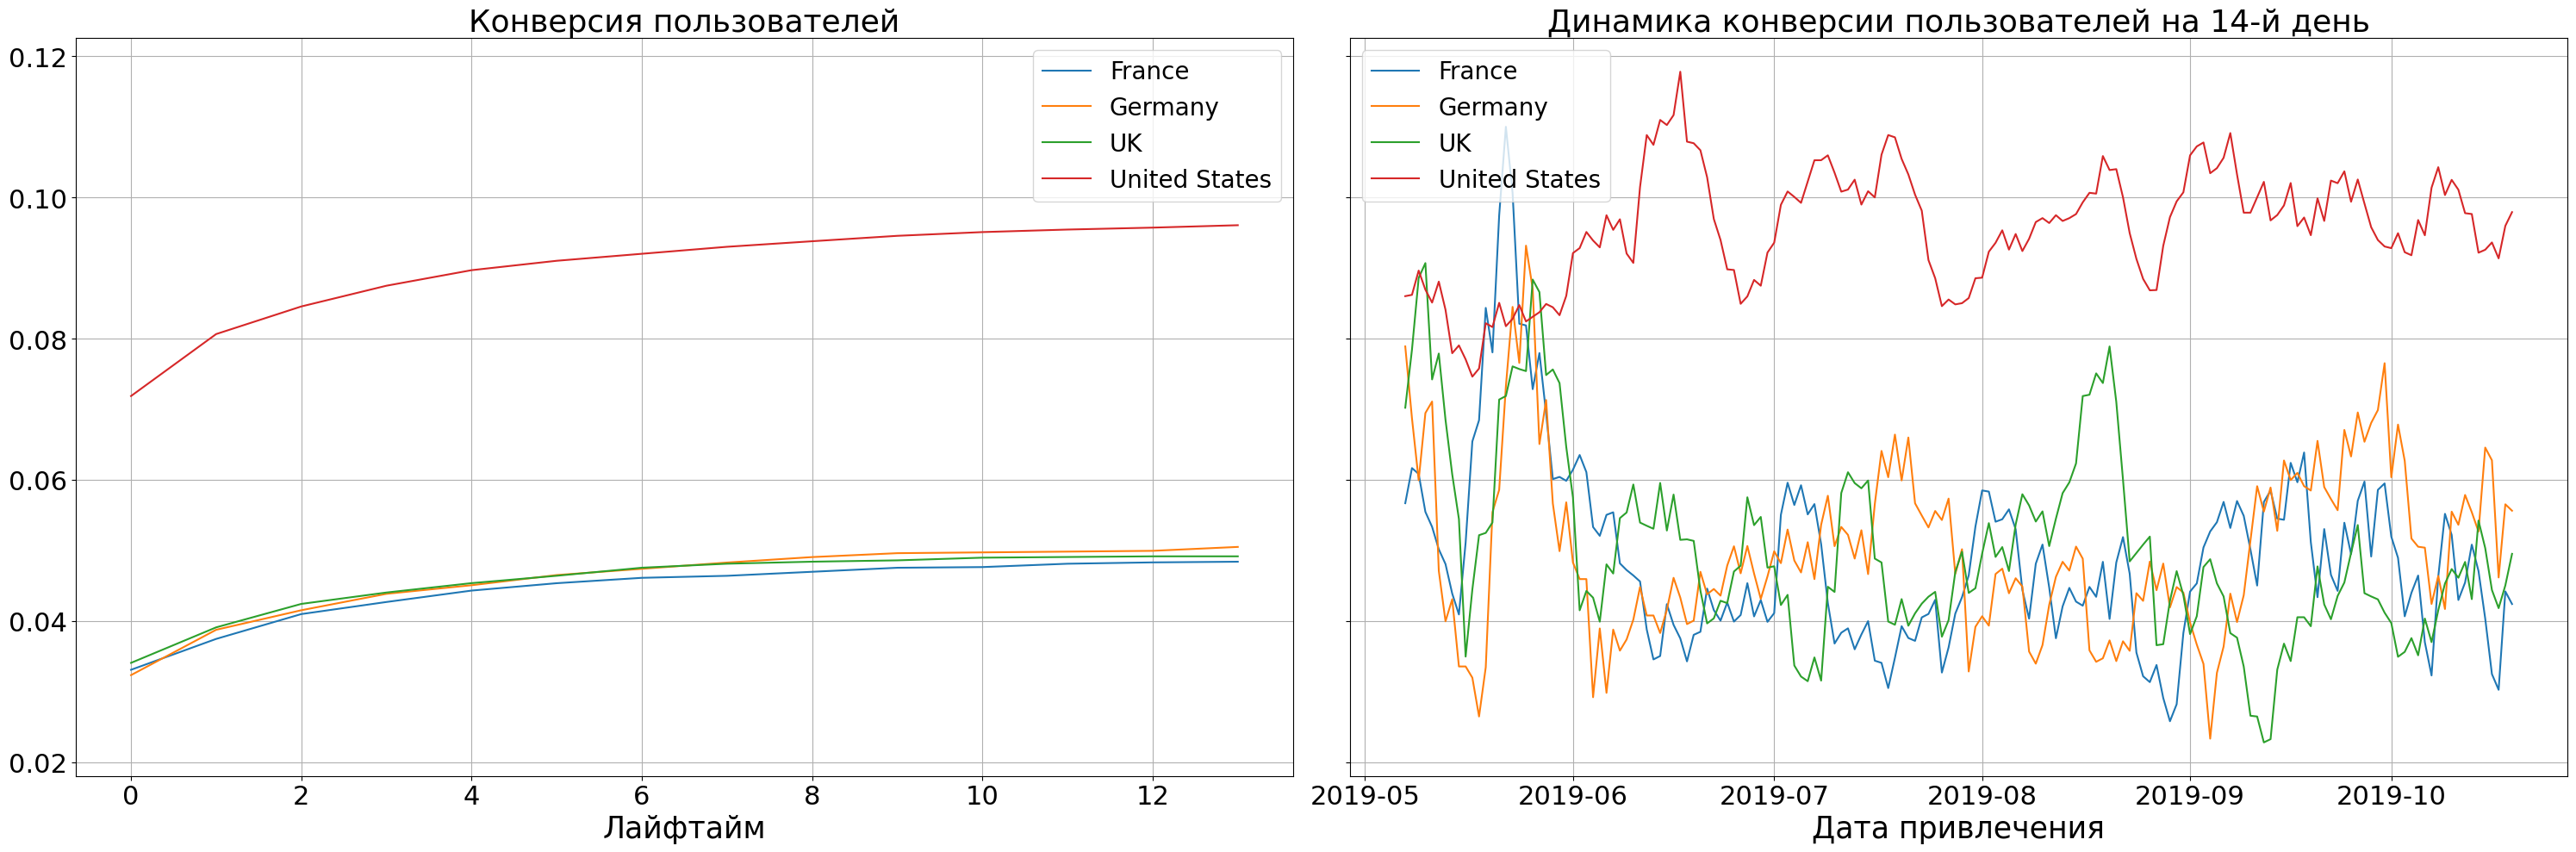

In [64]:
dimensions = ['region'] # конверсия с разбивкой по регионам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

На этих графиках сильно отличаются жители США. Их удержание заметно ниже других стран, при этом конверсия - выше.


#### Конверсия и удержание пользователей по каналам продвижения

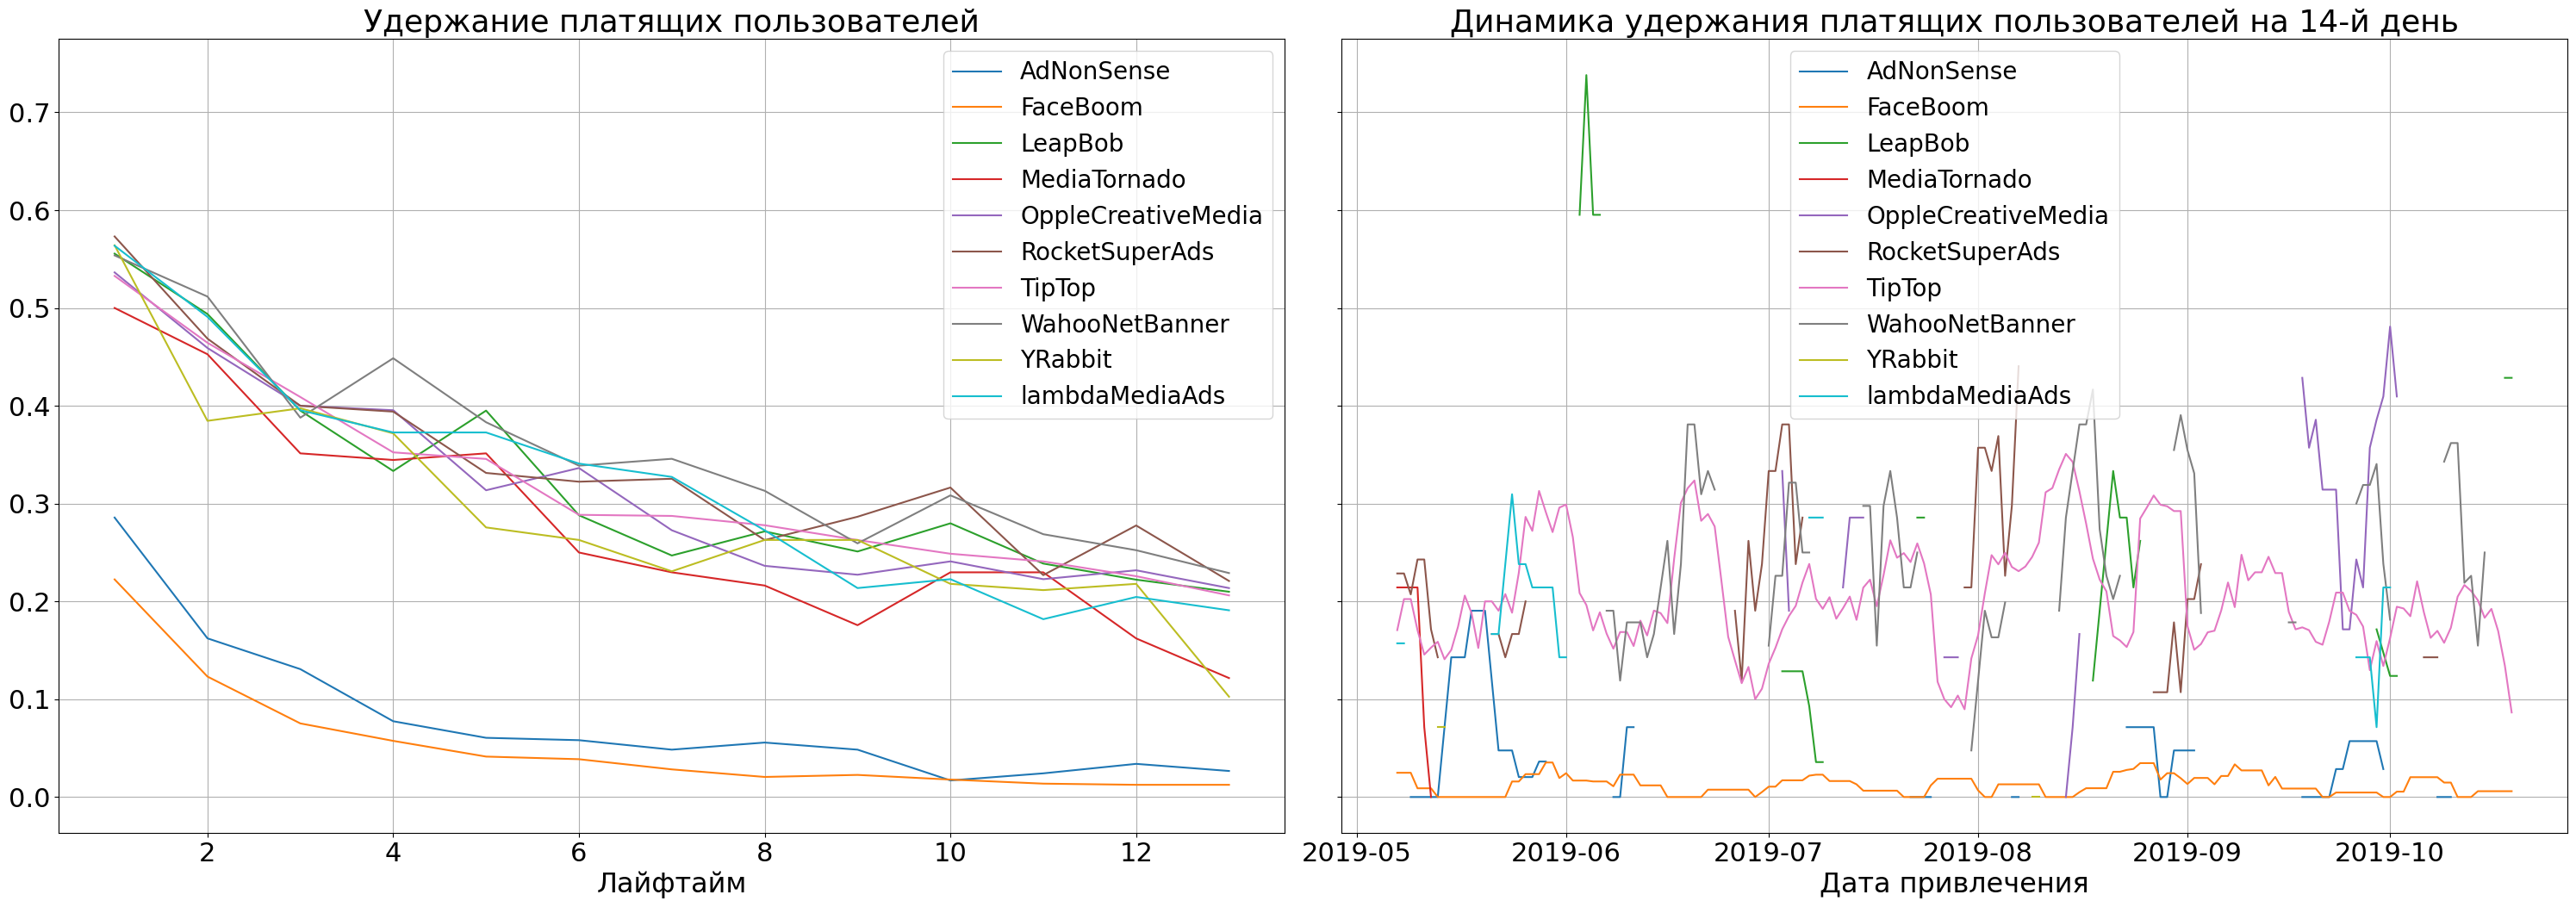

In [65]:
dimensions = ['channel'] # удержание с разбивкой по каналам продвижения
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions)

plot_retention(retention_grouped, retention_history, horizon_days)

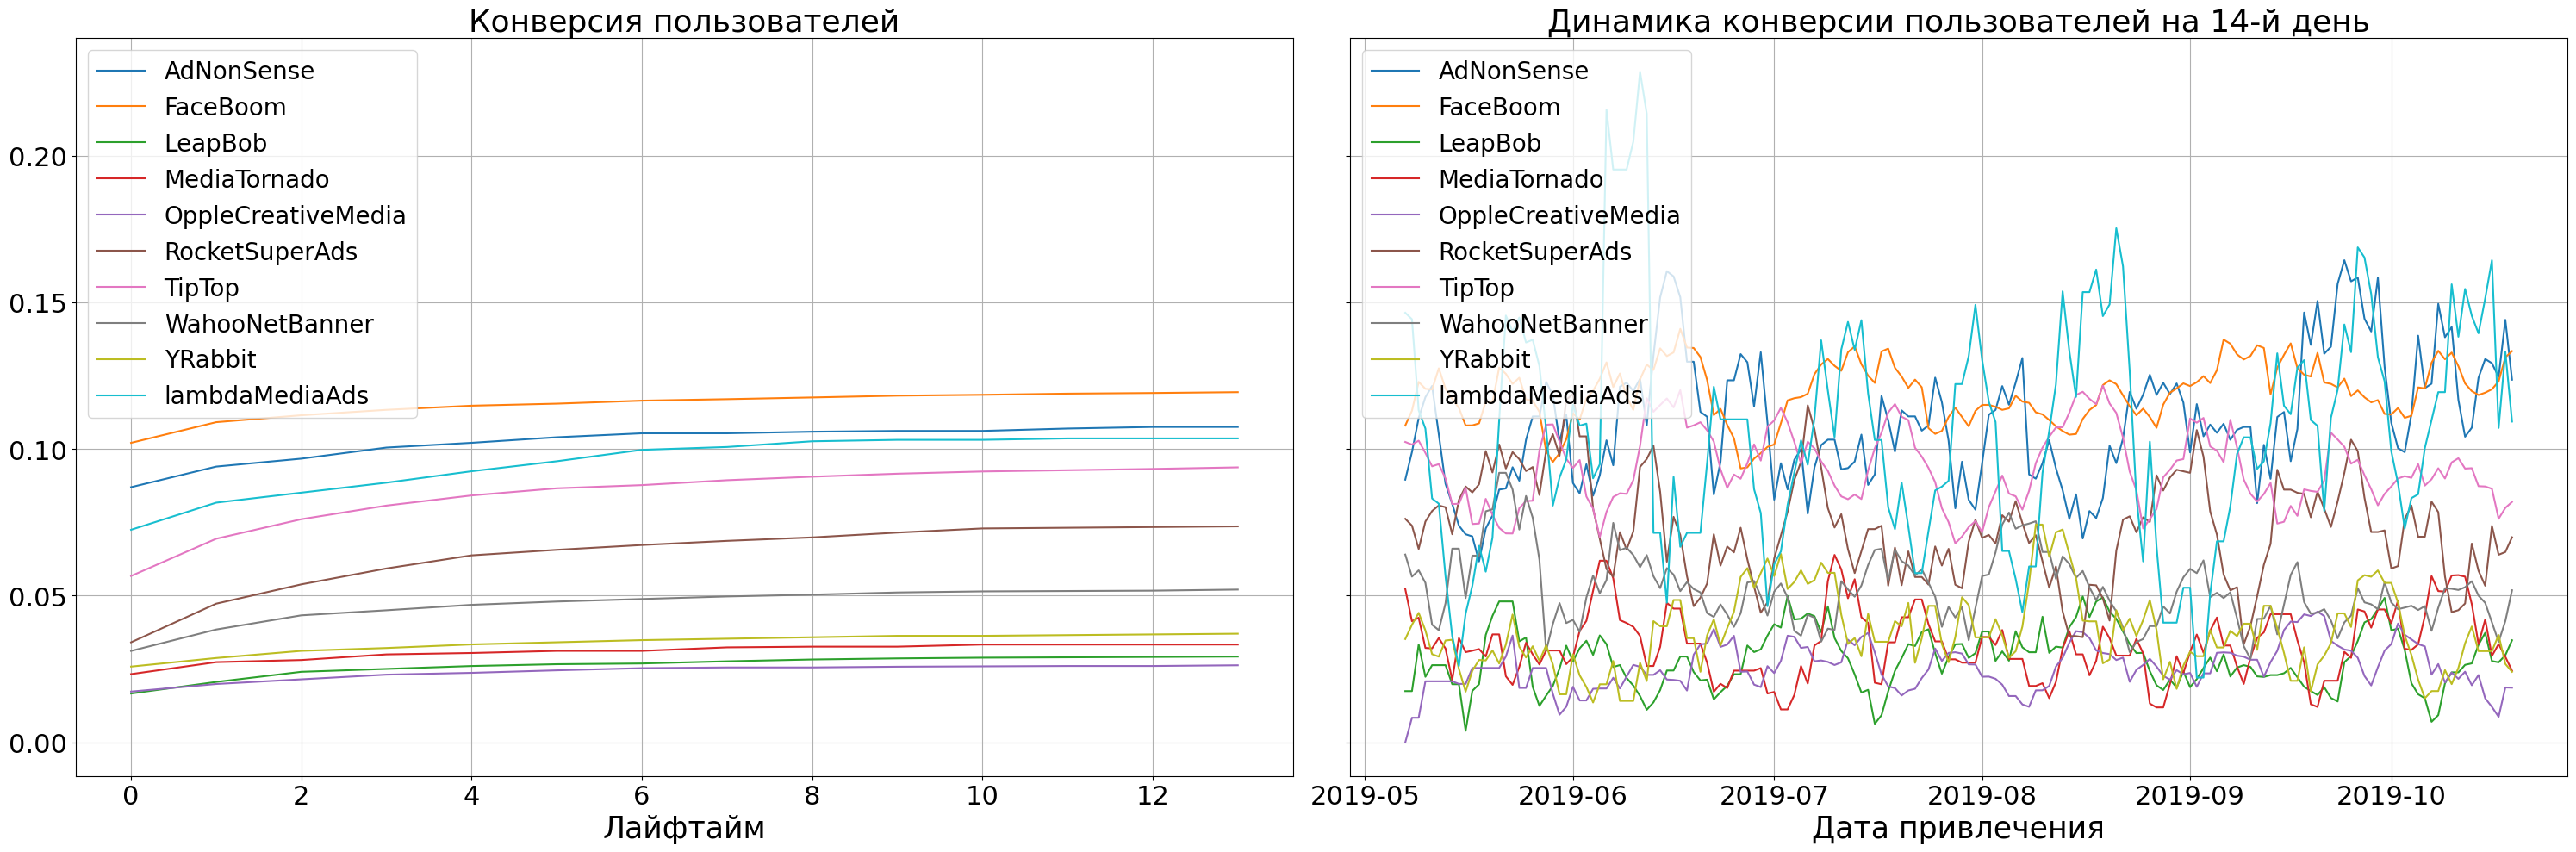

In [66]:
dimensions = ['channel'] # конверсия с разбивкой по каналам продвижения
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

По удержания выделяются два аутсайдера: FaceBoom (при том, что у него самый высокий уровень конверсии) и AdNonSense. По остальным каналам удержание, падая, остается на более высоком уровне. 

Посмотрим, во всех ли каналах, приводящих трафик в США, такое плохое удержание.

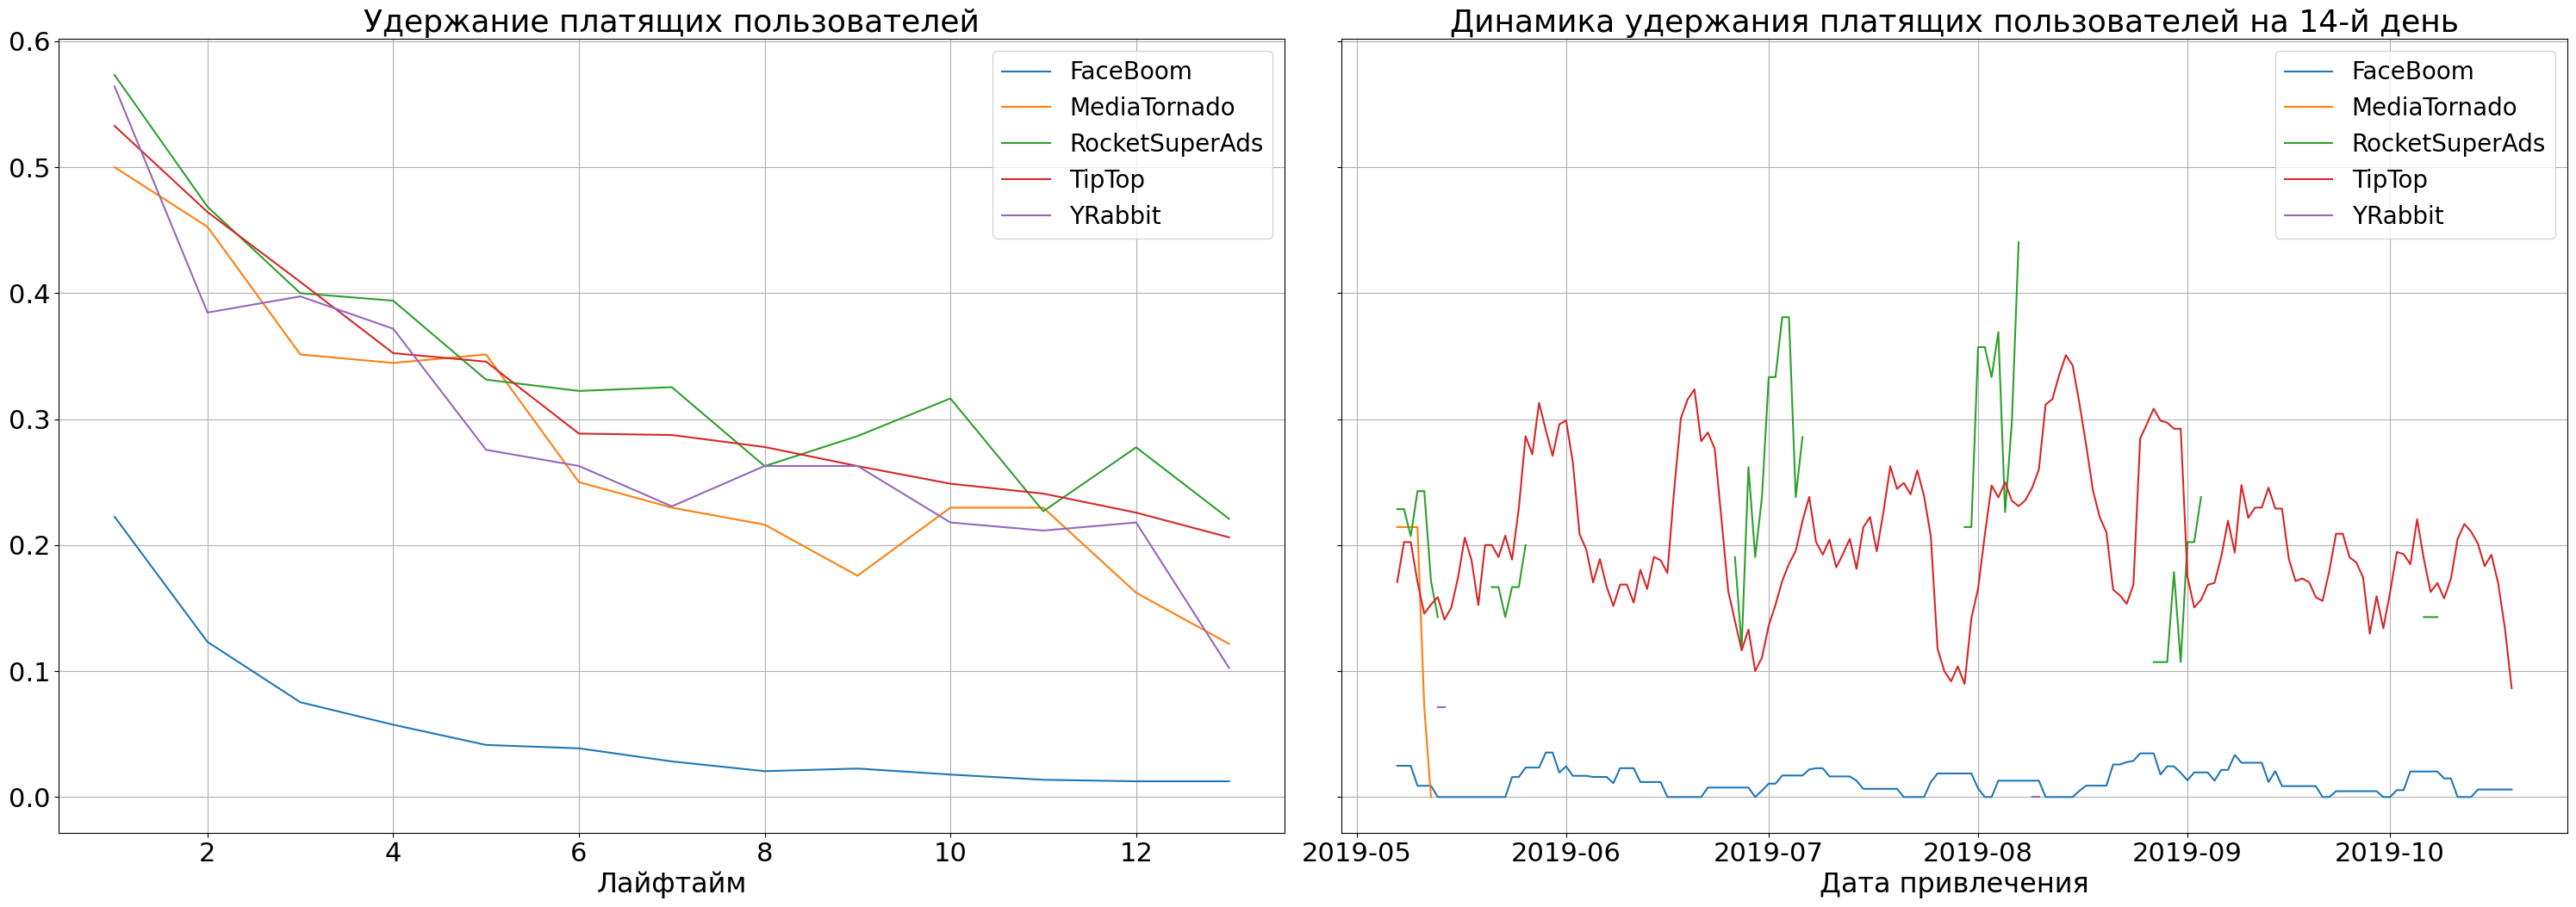

In [67]:
profiles = profiles.loc[profiles['channel'].isin(['FaceBoom', 'YRabbit', 'MediaTornado', 'RocketSuperAds', 'TipTop']) & (profiles['region'] == 'United States')]

dimensions = ['channel'] # удержание с разбивкой по каналам продвижения
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions)

plot_retention(retention_grouped, retention_history, horizon_days)

Удержание примерно на одном уровне у всех, кроме FaceBoom, он показывает совсем низкие результаты, к концу срока удержанных клинетов не остается совсем.

#### Выводы по оценке окупаемости рекламы

По результатам оценки окупаемости рекламы можно сделать выводы, что в целом реклама, направленная на привлечение пользователей, не окупается. Окупаемость со временем падает, а стоимость привлечения пользователей растет. Удержание платящих пользователей падает к концу двухнедельного срока до 10%.

В разрезе анализа по устройствам, мы увидели, что единственное устройство, на котором реклама окупается - это PC. При этом видна отрицательная динамика со временем, а конверсия имеет самое низкое значение. Остальные устройства находятся ниже уровня окупаемости и тоже падают со временем.

Стоимость привлечения по всем странам, кроме США, падает, и реклама во всех странах, кроме США, выходит на окупаемость. Конверсия и удержание в США также значительно ниже, чем в других регионах. Очевидно, что именно неокупаемость рекламы США, нашего самого большой рынка, влияет на негативные результаты по окупаемости по всем странам.

Только три канала привлечения находятся ниже уровня окупаемости: TipTop, FaceBoom, AdNonSense. Стоимости привлечения достаточно стабильны везде, кроме TipTop, у которого стоимость сильно растет со временем. FaceBoom и AdNonSense имеют самые низкие уровни удержания. 


### Выводы и рекомендации для отдела маркетинга


В данном исследовании мы проанализировали данные по пользователям приложения Procrastinate Pro+: лог сервера с данными об их посещениях, выгрузка их покупок за этот период и рекламные расходы. Нам были предоставлены данные о пользователях, привлеченных с 1 мая по 27 октября 2019 года. 

На первом этапе мы поработали с данными и подготовили их к анализу: поменяли типы данные, проверили данные на пропуски и дубликаты, привели названия к общепринятому виду, проверили текстовые задания на опечатки.

На втором этапе мы подготовили все функции, которые нам потребуются для исследования: функции для вычисления значений метрик и функции для построения графиков.

На третьем этапе мы составили пользовательские профили: 150008 профилей, в каждом из которых есть данные о дате первого посещения, канале продвижения (который мотивировал пользователя зайти на сайт), устройстве и регионе. Также в таблице есть информация о том, покупал ли пользователь что-нибудь, и о стоимости привлечения пользователя. Общая сумма затрат на рекламу за период - 105497.

По результатам анализа данных мы увидели, что США - самый большой рынок, опережающий по количеству пользователей каждый из остальных регионов более, чем в пять раз (66,7% всех пользователей). Великобритания и Франция - почти равны по количеству пользователей, и на последнем месте - Германия. При этом среди платящих пользователей жители США составляют 77,7%. При этом при разделении данных по странам, мы видим, что плачевная ситуация по окупаемости только в США, в остальных странах реклама окупается и расходы на нее падают со временем. Удержание в США также отстает от других стран (при самой высокой конверсии). ***Таким образом, только в США требуются меры по оптимизации рекламных расходов, в остальных странах можно работать только над улучшением показателей.***

Мы посмотрели распределение пользователей по девайсам. Пользователей IPhone больше всего (36%), пользователей Android, Mac и PC примерно по 20%. Среди платящих пользователей соотношение незначительно меняется, лидером также остается IPhone (38%). По окупаемости рекламы лидирует PC (единственное устройство, которое выходит на уровень окупаемости к концу второй недели), на остальных устройствах - не окупается. Хотя конверсия пользователей PC - наименьшая. Стоимость привлечения растет для всех устройств, для PC - в самой меньшей степени. В целом - по PC мы имеем самые положительные данные. Вероятно, приложение более "дружелюбно" к PC-пользователям. 
***Стоит присмотреться к интерфейсу PC и попробовать понять, чем реклама на PC отличается от остальных устройств.***

Больше всего пользователей приходят органическим путем (37,6%), а кроме них мы имеем 10 каналов продвижения: FaceBoom,        TipTop, OppleCreativeMedia, LeapBob, WahooNetBanner, RocketSuperAds, MediaTornado, YRabbit, AdNonSense, lambdaMediaAds (расположены по количеству привлеченных за рассматриваемый период пользователей).
Больше всего платящих пользователей пришло из FaceBoom и TipTop, а органические плательщики лишь на третьем месте. При этом и самые большие затраты на рекламу приходятся на эти  два канала, то есть понимаем, что именно в них было влито больше всего денег (более 80% всего бюджета). Расходы на эти два канала росли с течением времени. На остальные же каналы были довольно равномерно распределены остальные рекламные траты, и практически у всех средства были распределены равномерно по месяцам: затраты не росли, либо росли несильно. Безусловный лидер по средним затратам на одного привлеченного пользователя - TipTop (2,7 на одного пользователя), по остальным каналам продвижения на одного пользователя уходит от 1,1 до 0,2. 
При этом только три канала привлечения находятся ниже уровня окупаемости: TipTop, FaceBoom, AdNonSense. Первые два работают только в США, третий только в европейских странах. Стоимости привлечения достаточно стабильны везде, кроме TipTop, у которого стоимость сильно растет со временем. Таким образом, самые дорогие каналы привлечения не выходят на уровень окупаемости. ***Стоит отказаться от трех каналов привлечения (TipTop, FaceBoom в США и AdNonSense в Европе) в связи с их неэффективностью.***

***Также стоит ввести больше контроля за показателями маркетинга, чтобы быстрее получать сигналы о неэффективном расходованим рекламных средств.***




